In [76]:
# 금연에 도움이 된 보조제 조사

In [77]:
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 한글폰트 사용을 위한 설정(Window)
import matplotlib
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
# matplotlib.rc 또는 plt.rc 모두 가능
matplotlib.rc('font', family=font_name)

# 1. 한글 폰트 설정
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

금연클리닉 상담 기록에서 지역별 금연 성공률(전체 데이터 양과 6개월 평가 성공부 비교), 

In [3]:
income = pd.read_csv('../data/personal_income.csv')
smoke1 = pd.read_csv('../data/smoke1.csv')
pop_df = pd.read_csv('../data/Regional_Population_2023.csv')

print(smoke1.info())
print(income.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235379 entries, 0 to 235378
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   기관유형              235379 non-null  object 
 1   지역                235379 non-null  object 
 2   서비스구분             235379 non-null  object 
 3   제공기관              235379 non-null  object 
 4   출생년도              235379 non-null  object 
 5   성별                235379 non-null  object 
 6   등록일자(년도)          235379 non-null  int64  
 7   등록일자(월)           235379 non-null  int64  
 8   등록유형              235379 non-null  object 
 9   금연결심일자(년도)        231278 non-null  float64
 10  금연결심일자(월)         231278 non-null  float64
 11  상담횟수              235061 non-null  float64
 12  서비스상태             235379 non-null  object 
 13  종결일자(년도)          132216 non-null  float64
 14  종결일자(월)           132216 non-null  float64
 15  4주평가성공여부          235379 non-null  object 
 16  4주평가방법            15

# 전체 금연 데이터 중 남/여 인원수

([<matplotlib.axis.YTick at 0x2280538ca00>,
 [Text(0, 30000, '30,000'),
  Text(0, 100000, '100,000'),
  Text(0, 200000, '200,000')])

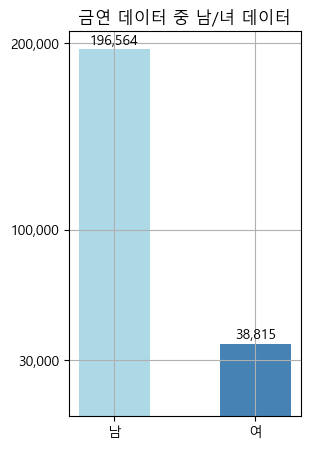

In [80]:
index_ = smoke1.groupby('성별').size().index
count_ = smoke1.groupby('성별').size()


plt.figure(figsize=(3,5))
plt.bar(index_, count_, width=0.5, color = ['#ADD8E6', '#4682B4'])

offset = 3000
labels = ['남', '여']

for sex, num in enumerate(count_):
    plt.text(
        sex,
        num + offset,
        f"{num:,.0f}",
        fontsize = 10,
        ha = 'center',
        
    )

plt.title('금연 데이터 중 남/녀 데이터')
plt.grid()
plt.yticks([30000, 100000, 200000], ['30,000', '100,000' ,'200,000'])

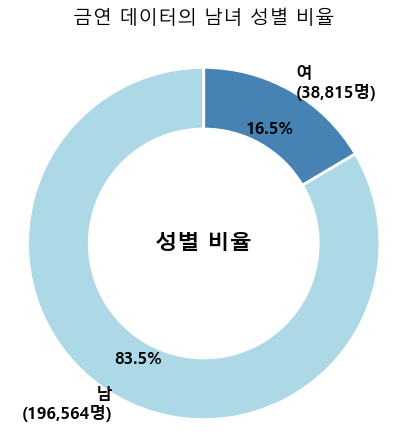

In [91]:
# 1. 캔버스 및 축 생성
fig, ax = plt.subplots(figsize=(5, 5))

# 2. 색상 팔레트 선택 (Set2, Pastel, Coolwarm 등 사용 가능)
# colors = plt.cm.Set2.colors[:len(count_)]
colors = ["#ADD8E6" ,"#4682B4" ]

# 3. 도넛 차트 스타일을 위한 설정
wedgeprops = {
    'width': 0.35,  # 도넛 두께 (0.0은 일반 파이 차트, 1.0은 원이 사라짐)
    'edgecolor': 'white', # 섹션 간 흰색 테두리
    'linewidth': 2        # 테두리 두께
}

# 4. 텍스트 레이블 생성 (레이블과 인원수를 묶음)
labels_with_count = [f"{idx}\n({val:,}명)" for idx, val in zip(count_.index, count_.values)]

text_properties = {
    'color': 'black',  # 텍스트 색상을 어두운 회색으로 설정
    'fontsize': 12,      # 폰트 크기 설정
    'fontweight': 'bold' # 글씨를 굵게 설정
}

plt.pie(
    count_.values,
    # labels=labels_with_count, # 밖으로 빼내거나 autopct 안에 포함시켜 깔끔하게 처리
    autopct='%1.1f%%',
    colors=colors,    
    wedgeprops=wedgeprops,
    startangle=90, # 90도에서 시작하여 더 안정적인 시각 제공
    pctdistance=0.75, # 백분율 텍스트를 중앙으로 이동
    labels=labels_with_count, # 외부 레이블 추가
    labeldistance=1.05, # 레이블 위치 조정
    textprops=text_properties
)

# 5. 중앙 타이틀/주석 추가 (도넛 차트의 빈 공간 활용)
ax.text(0, 0, '성별 비율', 
        ha='center', va='center', 
        fontsize=16, 
        fontweight='bold')

plt.title('금연 데이터의 남녀 성별 비율', fontsize=14, pad=20)
plt.axis('equal') # 원형을 유지
plt.show()

# 연령대별 성별 인원수

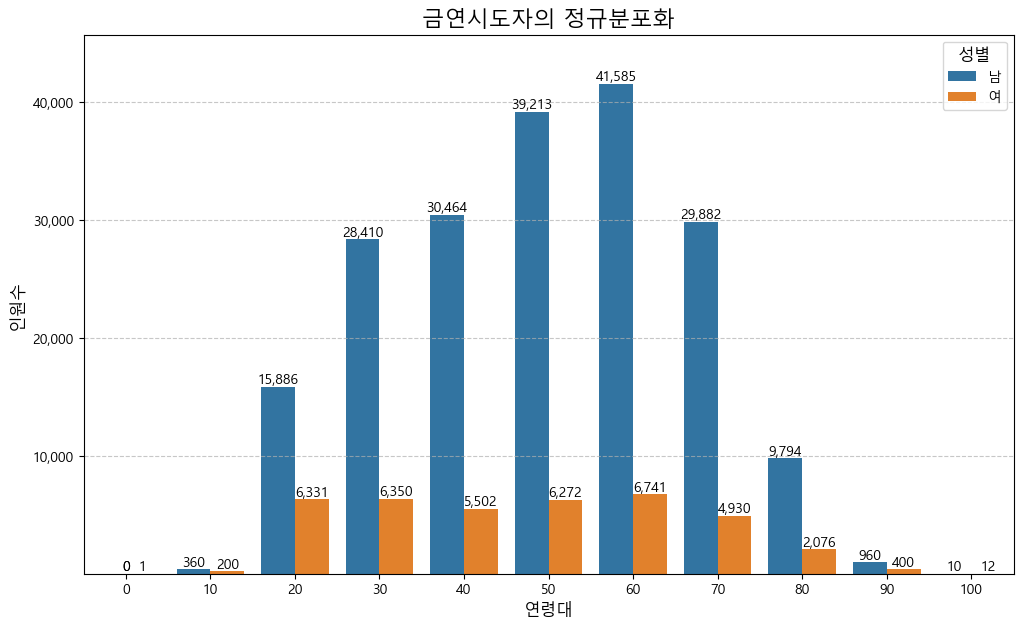

In [93]:
# 2. 데이터 전처리 (이전 코드와 동일)
# '출생년도_시작' 컬럼 생성
smoke1['출생년도_시작'] = smoke1['출생년도'].str.split('~').str[0].astype(int)
# '나이' 컬럼 생성 (2025년 기준)
smoke1['나이'] = 2025 - smoke1['출생년도_시작']
# '연령대' 컬럼 생성 (10의 자리로 내림)
smoke1['연령대'] = (smoke1['나이'] // 10) * 10

# 3. 연령대별 성별 수 집계
age_sex_counts = smoke1.groupby(['연령대', '성별']).size().reset_index(name='count')

# 4. 시각화 및 데이터 값 표시
plt.figure(figsize=(12, 7))

# Seaborn barplot 생성
ax = sns.barplot(
    data=age_sex_counts,
    x='연령대',
    y='count',
    hue='성별',
    hue_order=['남', '여']
)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 5,
        f'{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )
# --------------------------------------------------------------------

plt.yticks([10000, 20000, 30000, 40000], ['10,000', '20,000', '30,000', '40,000'])
plt.title('금연시도자의 정규분포화', fontsize=16)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('인원수', fontsize=12)
plt.legend(title='성별', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, age_sex_counts['count'].max() * 1.1)
plt.show()

# 지역별 금연 등록자 수

C:\Users\OWNER\AppData\Local\Temp\ipykernel_744\2187694627.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


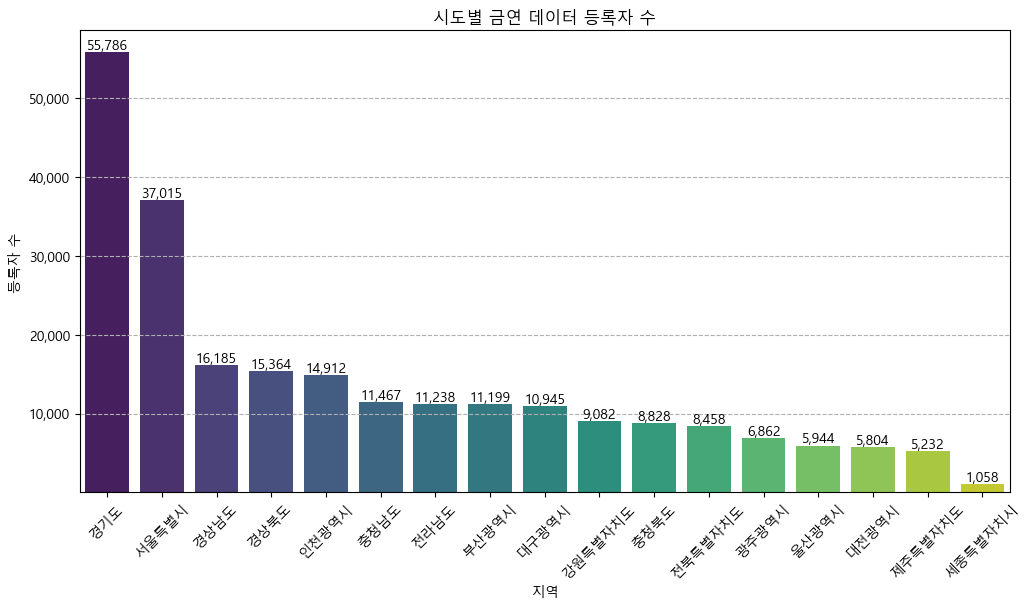

In [4]:
region_counts = smoke1.groupby('지역').size().reset_index(name='count')

# 지역 수가 많으면 내림차순 정렬
region_counts = region_counts.sort_values(by='count', ascending=False)

# 시각화
plt.figure(figsize=(12,6))

ax = sns.barplot(
    data=region_counts,
    x='지역',
    y='count',
    palette='viridis'
)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 5,
        f'{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.yticks([10000, 20000, 30000, 40000, 50000], ['10,000', '20,000', '30,000', '40,000', '50,000'])
plt.grid(axis='y', linestyle='--')
plt.title('시도별 금연 데이터 등록자 수')
plt.xlabel('지역')
plt.ylabel('등록자 수')
plt.xticks(rotation=45)  # x축 라벨 기울이기
plt.show()

# 지역별 인구 대비 금연 클리닉 등록 비율

C:\Users\OWNER\AppData\Local\Temp\ipykernel_744\2762036382.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=merged_df, x='지역', y='금연시도율(%)', palette='viridis', order=x_order)


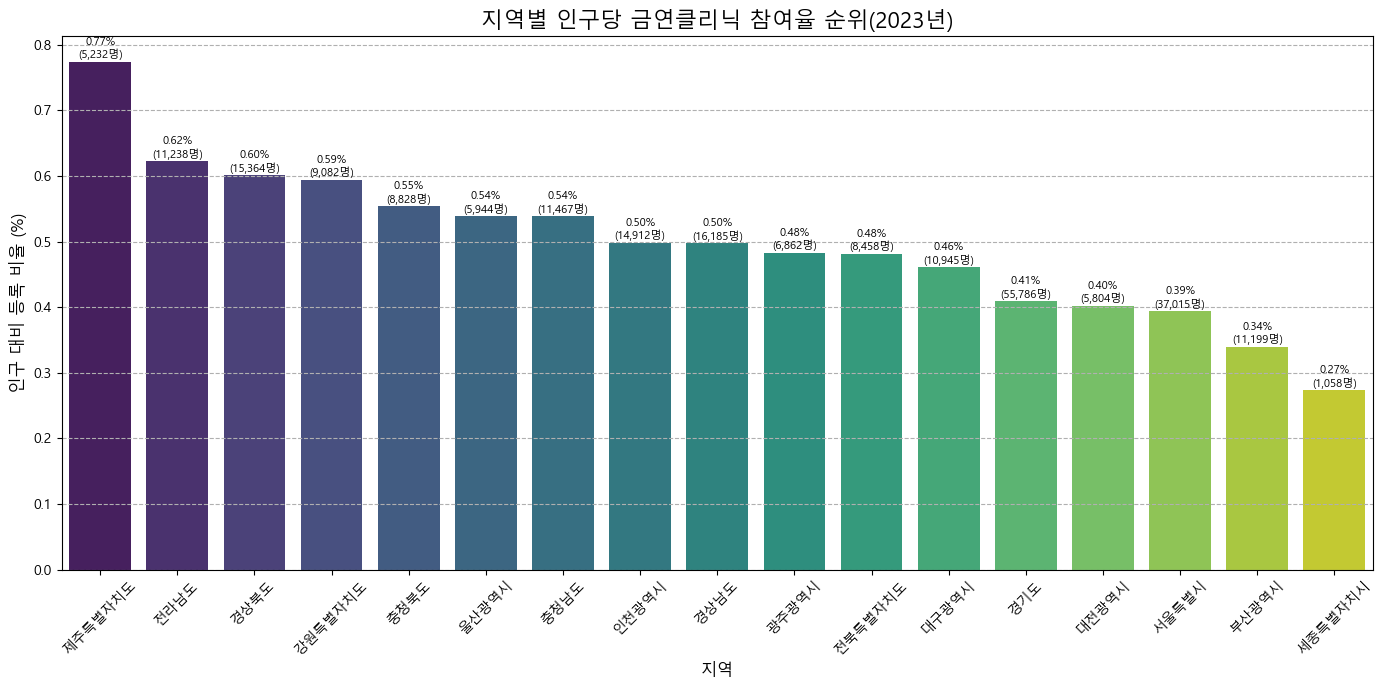

         지역   등록자수     총인구수  금연시도율(%)
14  제주특별자치도   5232   675845  0.774142
12     전라남도  11238  1804875  0.622647
3      경상북도  15364  2556262  0.601034
0   강원특별자치도   9082  1528635  0.594125
16     충청북도   8828  1594038  0.553814


In [11]:
# 3. 인구 데이터 전처리 (위치 기반 선택: 지역, 총인구수)
pop_df_clean = pop_df.iloc[:, [0, 1]].copy()
pop_df_clean.columns = ['지역', '총인구수']

# -------------------------------------------------------------------------
# [핵심 수정] 데이터를 숫자로 강제 변환하는 과정 (여기가 제일 중요합니다!)
# -------------------------------------------------------------------------
# (1) 쉼표(,) 제거: 문자로 변환 후 replace
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(str).str.replace(',', '')

# (2) 숫자로 변환: '총인구수 (명)' 같은 글자는 NaN(빈값)으로 변환 (errors='coerce')
pop_df_clean['총인구수'] = pd.to_numeric(pop_df_clean['총인구수'], errors='coerce')

# (3) NaN(빈값) 제거: 변환에 실패한 행(제목줄 등)을 삭제
pop_df_clean = pop_df_clean.dropna()

# (4) 소수점(.0) 등이 있을 수 있으므로 정수(int)로 깔끔하게 변환
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(int)

# '전국' 데이터 제외
pop_df_clean = pop_df_clean[pop_df_clean['지역'] != '전국']


# 4. 금연 데이터 집계
region_counts = smoke1.groupby('지역').size().reset_index(name='등록자수')

# 5. 데이터 병합
merged_df = pd.merge(region_counts, pop_df_clean, on='지역', how='inner')

# -------------------------------------------------------------------------
# [에러 해결] 이제 둘 다 숫자이므로 계산이 됩니다.
# -------------------------------------------------------------------------
merged_df['금연시도율(%)'] = (merged_df['등록자수'] / merged_df['총인구수']) * 100
merged_df = merged_df.sort_values(by='금연시도율(%)', ascending=False)

plt.figure(figsize=(14, 7))
# merged_df가 금연시도율(%) 기준으로 정렬되어 있으므로, 
# x축 순서에 맞게 지역 목록을 추출하여 사용합니다.
x_order = merged_df['지역'].tolist() 
barplot = sns.barplot(data=merged_df, x='지역', y='금연시도율(%)', palette='viridis', order=x_order)

plt.title('지역별 인구당 금연클리닉 참여율 순위(2023년)', fontsize=16)
plt.xlabel('지역', fontsize=12)
plt.ylabel('인구 대비 등록 비율 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle = '--')

for i, p in enumerate(barplot.patches):
    # 막대의 높이 (등록 비율 값)
    rate_height = p.get_height()
    
    # 1. 현재 막대에 해당하는 지역 이름 추출 (x축 라벨)
    current_region = x_order[i]
    
    # 2. 해당 지역의 등록자수 데이터프레임에서 찾기
    registrants = merged_df[merged_df['지역'] == current_region]['등록자수'].item()
    
    # 3. 텍스트 포맷팅 (등록비율을 소수점 3자리까지, 등록자수에 쉼표 구분 기호 추가)
    # 텍스트 포맷: 0.xxx% (X,XXX명)
    text_label = f'{rate_height:.2f}%\n({registrants:,}명)'
    
    # 텍스트 출력
    # 텍스트를 막대 상단보다 약간 더 위로 올리기 위해 height + 0.0005 사용
    plt.text(p.get_x() + p.get_width() / 2., rate_height + 0.0005, 
             text_label, 
             ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()

# 결과 확인
print(merged_df[['지역', '등록자수', '총인구수', '금연시도율(%)']].head())

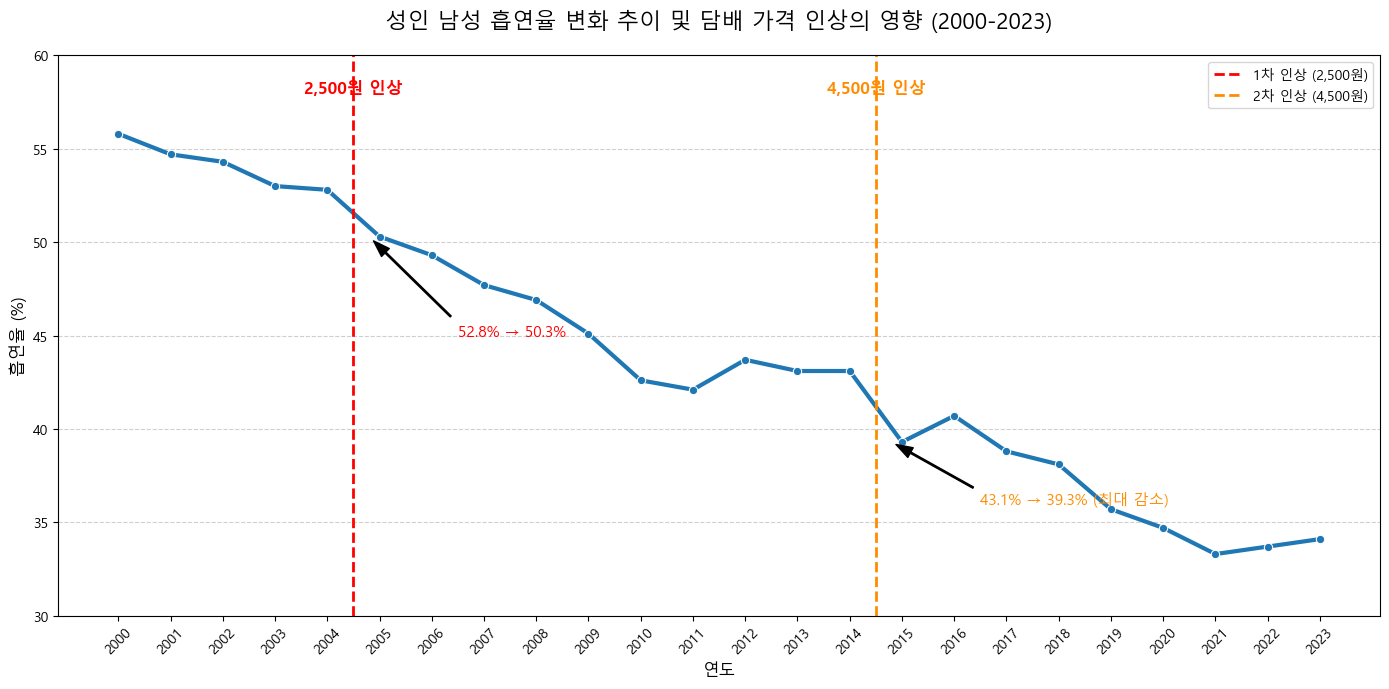

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 📌 예시 데이터 (실제 통계 자료를 기반으로 한 예시 값) ---
# 연도별 성인 남성 흡연율 (만 19세 이상)
data = {
    'Year': list(range(2000, 2024)),
    'Smoking_Rate': [
        55.8, 54.7, 54.3, 53.0, 52.8, 50.3, 49.3, 47.7, 46.9, 45.1,
        42.6, 42.1, 43.7, 43.1, 43.1, 39.3, 40.7, 38.8, 38.1, 35.7,
        34.7, 33.3, 33.7, 34.1  # 2019년 이후는 30대 중반 수준 유지
    ]
}
df = pd.DataFrame(data)

# --- 1. 그래프 생성 ---
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    x='Year', 
    y='Smoking_Rate', 
    data=df, 
    marker='o', 
    linewidth=3, 
    color='#1F77B4'
)

# --- 2. 담배 가격 인상 시점 강조 (수직선) ---
# 2004년 말 (2005년 데이터에 영향)
ax.axvline(x=2004.5, color='red', linestyle='--', linewidth=2, label='1차 인상 (2,500원)')
# 2015년 초 (2015년 데이터에 영향)
ax.axvline(x=2014.5, color='darkorange', linestyle='--', linewidth=2, label='2차 인상 (4,500원)')


# --- 3. 텍스트 라벨 추가 (인상 정보) ---
# 1차 인상 (2004.5)
ax.text(2004.5, 58, '2,500원 인상', color='red', fontsize=12, ha='center', fontweight='bold')
# 2차 인상 (2014.5)
ax.text(2014.5, 58, '4,500원 인상', color='darkorange', fontsize=12, ha='center', fontweight='bold')


# --- 4. 시각화 세부 설정 ---
plt.title('성인 남성 흡연율 변화 추이 및 담배 가격 인상의 영향 (2000-2023)', fontsize=16, pad=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('흡연율 (%)', fontsize=12)

# X축 눈금 조정 (연도 전체 표시)
plt.xticks(data['Year'], rotation=45) 
plt.ylim(30, 60) # Y축 범위 조정으로 변화 폭 부각
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

# --- 5. 감소된 포인트 강조 (2005년, 2015년) ---
# 2005년 (2004.5 인상 후)
rate_2004 = df[df['Year'] == 2004]['Smoking_Rate'].iloc[0]
rate_2005 = df[df['Year'] == 2005]['Smoking_Rate'].iloc[0]
plt.annotate(
    f'{rate_2004:.1f}% → {rate_2005:.1f}%', 
    xy=(2004.8, rate_2005), 
    xytext=(2006.5, 45), # 주석 위치
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
    fontsize=11, 
    color='red'
)

# 2015년 (2014.5 인상 후)
rate_2014 = df[df['Year'] == 2014]['Smoking_Rate'].iloc[0]
rate_2015 = df[df['Year'] == 2015]['Smoking_Rate'].iloc[0]
plt.annotate(
    f'{rate_2014:.1f}% → {rate_2015:.1f}% (최대 감소)', 
    xy=(2014.8, rate_2015), 
    xytext=(2016.5, 36), 
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
    fontsize=11, 
    color='darkorange'
)

plt.tight_layout()
plt.show()

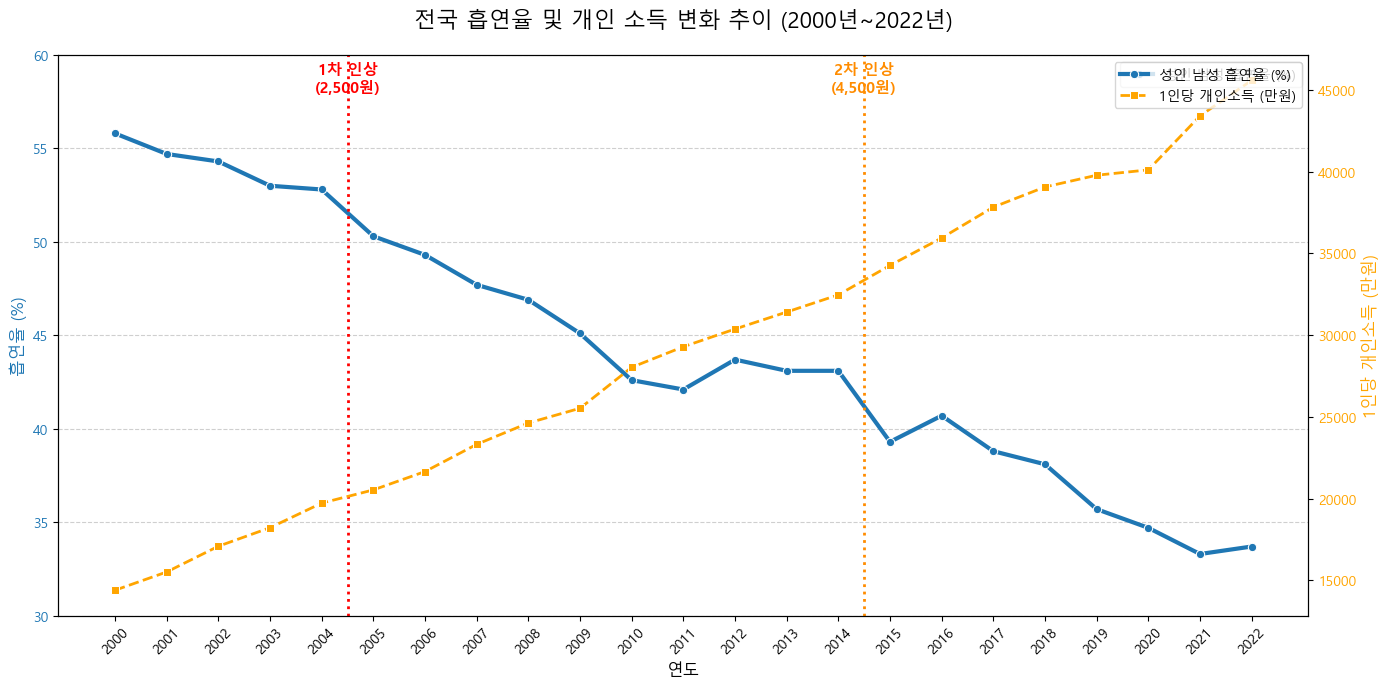

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 📌 1. 데이터 로드 및 전처리 ---
# personal_income.csv에서 전국 데이터를 추출하여 연도별 데이터프레임 생성
INCOME_FILE = '../data/personal_income.csv'

# 데이터 로드 및 전국 행 추출
try:
    income_df_raw = pd.read_csv(INCOME_FILE, header=0)
except FileNotFoundError:
    print("Error: personal_income.csv 파일을 찾을 수 없습니다.")
    exit()

# '전국' 행 추출
national_income = income_df_raw[income_df_raw['시도별'] == '전국'].iloc[0]

# 연도별 데이터 추출 및 클리닝
years = national_income.index[1:].tolist()
income_values = national_income.values[1:].tolist()

# 데이터를 정리할 DataFrame 생성
income_data = pd.DataFrame({
    'Year': [int(y.split(' ')[0]) for y in years], # 연도만 추출하여 정수형으로 변환
    'Income_KRW': pd.to_numeric(income_values, errors='coerce') # '-' 값 등을 NaN으로 처리
}).dropna()

# 2023년 데이터는 '2023 p)'로 추정치이므로, 이를 제외하고 2022년까지만 사용하거나, 
# 'p)'를 제거하고 사용해야 하나, 여기서는 편의상 그대로 사용합니다.

# --- 📌 2. 흡연율 예시 데이터 (이전 코드와 동일한 구조 사용) ---
# 연도별 성인 남성 흡연율 (만 19세 이상) 예시 데이터
smoking_data = {
    'Year': list(range(2000, 2023)), # 소득 데이터에 맞게 2022년까지만 사용
    'Smoking_Rate': [
        55.8, 54.7, 54.3, 53.0, 52.8, 50.3, 49.3, 47.7, 46.9, 45.1,
        42.6, 42.1, 43.7, 43.1, 43.1, 39.3, 40.7, 38.8, 38.1, 35.7,
        34.7, 33.3, 33.7  # 2023년 데이터는 소득 데이터와 맞추기 위해 제외
    ]
}
smoking_df = pd.DataFrame(smoking_data)

# 데이터프레임 병합 (Year 기준)
df_merged = pd.merge(smoking_df, income_data, on='Year', how='inner')


# --- 3. 이중 축 시각화 (Two Axes Plot) ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# --- Ax1: 흡연율 (왼쪽 Y축) ---
color_rate = '#1F77B4' # 파란색
sns.lineplot(
    x='Year', 
    y='Smoking_Rate', 
    data=df_merged, 
    marker='o', 
    linewidth=3, 
    color=color_rate,
    label='성인 남성 흡연율 (%)',
    ax=ax1
)
ax1.set_xlabel('연도', fontsize=12)
ax1.set_ylabel('흡연율 (%)', color=color_rate, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_rate)
ax1.set_ylim(30, 60) # 흡연율 변화를 부각

# --- Ax2: 개인 소득 (오른쪽 Y축) ---
ax2 = ax1.twinx() # X축을 공유하는 새로운 Y축 생성
color_income = '#FFA500' # 주황색
sns.lineplot(
    x='Year', 
    y='Income_KRW', 
    data=df_merged, 
    marker='s', 
    linestyle='--',
    linewidth=2,
    color=color_income,
    label='1인당 개인소득 (만원)',
    ax=ax2
)
ax2.set_ylabel('1인당 개인소득 (만원)', color=color_income, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color_income)

# --- 4. 담배 가격 인상 시점 강조 ---
# 2004년 말 (2005년 데이터에 영향)
ax1.axvline(x=2004.5, color='red', linestyle=':', linewidth=2)
ax1.text(2004.5, 58, '1차 인상\n(2,500원)', color='red', fontsize=11, ha='center', fontweight='bold')
# 2015년 초 (2015년 데이터에 영향)
ax1.axvline(x=2014.5, color='darkorange', linestyle=':', linewidth=2)
ax1.text(2014.5, 58, '2차 인상\n(4,500원)', color='darkorange', fontsize=11, ha='center', fontweight='bold')


# --- 5. 시각화 최종 설정 ---
plt.title('전국 흡연율 및 개인 소득 변화 추이 (2000년~2022년)', fontsize=16, pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.set_xticks(df_merged['Year'])
ax1.tick_params(axis='x', rotation=45)

# 범례 통합 표시 (두 축의 라벨을 모두 가져와서 한 곳에 표시)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# 등록자 수 vs 인구 대비 등록 비율 비교

C:\Users\OWNER\AppData\Local\Temp\ipykernel_744\764992804.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=merged_df_sorted, x='지역', y='등록자수', ax=axes[0], palette='viridis')
C:\Users\OWNER\AppData\Local\Temp\ipykernel_744\764992804.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df_sorted, x='지역', y='금연시도율(%)', ax=axes[1], palette='plasma')


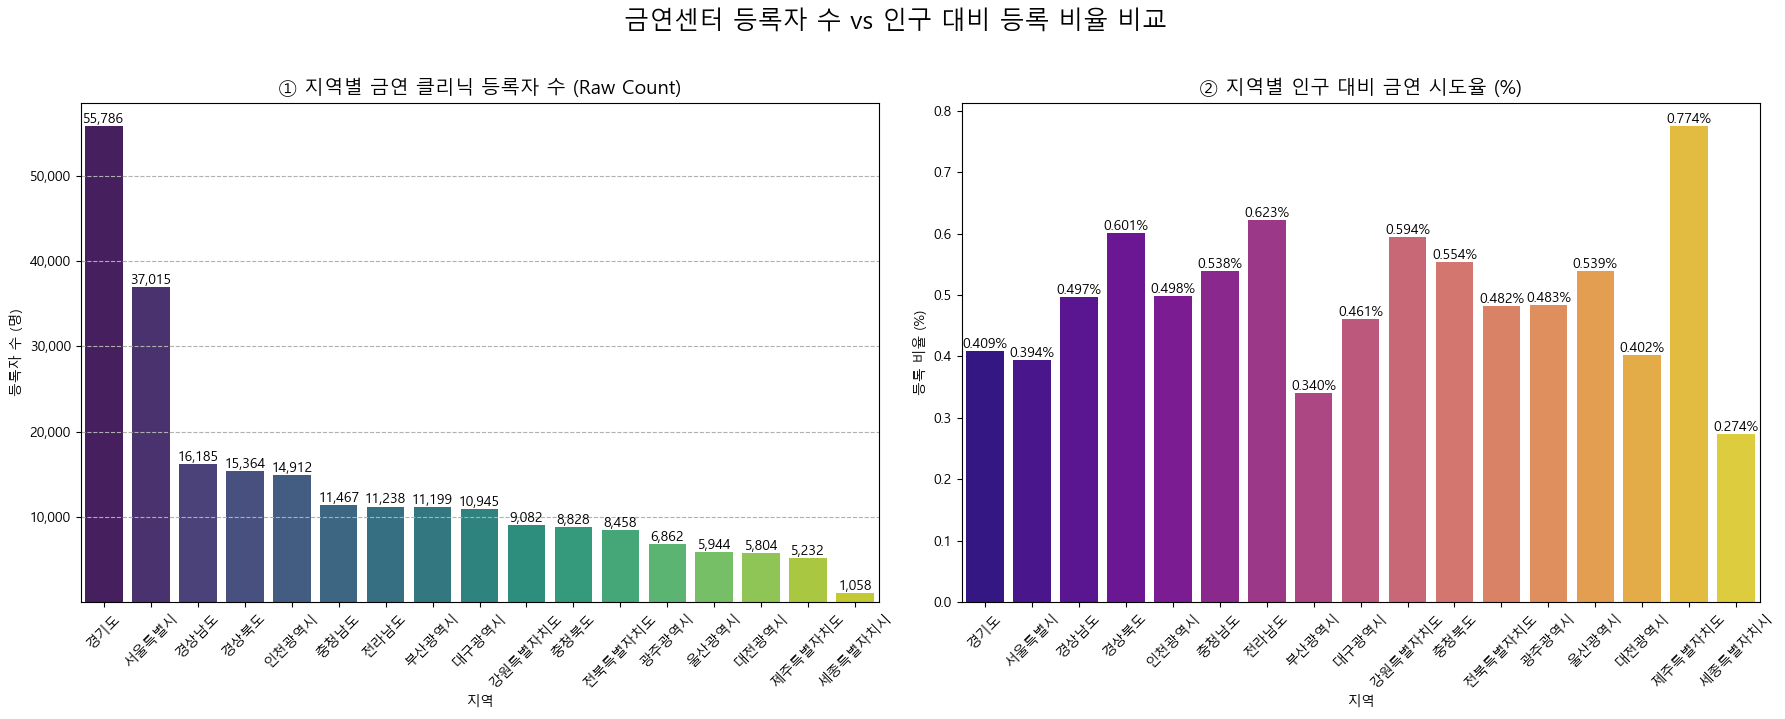

In [ ]:
# 3. 인구 데이터 전처리 및 클리닝 (위치 기반 선택 및 오류 제거)
pop_df_clean = pop_df.iloc[:, [0, 1]].copy()
pop_df_clean.columns = ['지역', '총인구수']

# (1) 쉼표(,) 제거 및 문자열 변환
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(str).str.replace(',', '')

# (2) 숫자로 변환 시도: 글자는 NaN으로 (errors='coerce')
pop_df_clean['총인구수'] = pd.to_numeric(pop_df_clean['총인구수'], errors='coerce')

# (3) NaN(빈값)이 된 행을 삭제하고 정수형으로 변환
pop_df_clean = pop_df_clean.dropna(subset=['총인구수'])
pop_df_clean['총인구수'] = pop_df_clean['총인구수'].astype(int)

# '전국' 데이터 제외
pop_df_clean = pop_df_clean[pop_df_clean['지역'] != '전국']


# 4. 금연 데이터 집계 및 병합
region_counts = smoke1.groupby('지역').size().reset_index(name='등록자수')
merged_df = pd.merge(region_counts, pop_df_clean, on='지역', how='inner')

# 5. 비율 계산
merged_df['금연시도율(%)'] = (merged_df['등록자수'] / merged_df['총인구수']) * 100

# ------------------------------------------------------------------------
# [수정된 부분] '등록자수'가 높은 순서로 정렬 (두 그래프에 동일 적용)
merged_df_sorted = merged_df.sort_values(by='등록자수', ascending=False)
# ------------------------------------------------------------------------


# 6. 두 개의 서브플롯으로 시각화하여 비교
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) 
plt.suptitle('금연센터 등록자 수 vs 인구 대비 등록 비율', fontsize=18, y=1.02)

# --- [Plot 1: Raw Count (등록자 수)] ---
ax = sns.barplot(data=merged_df_sorted, x='지역', y='등록자수', ax=axes[0], palette='viridis')
axes[0].set_title('① 지역별 금연 클리닉 등록자 수 (Raw Count)', fontsize=14)
axes[0].set_xlabel('지역')
axes[0].set_ylabel('등록자 수 (명)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_yticks([10000, 20000, 30000, 40000, 50000], ['10,000', '20,000', '30,000', '40,000', '50,000'])
axes[0].grid(axis='y', linestyle='--')
# 수치 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 5,
        f'{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

    
# --- [Plot 2: Rate (금연시도율)] ---
sns.barplot(data=merged_df_sorted, x='지역', y='금연시도율(%)', ax=axes[1], palette='plasma')
axes[1].set_title('② 지역별 인구 대비 금연 시도율 (%)', fontsize=14)
axes[1].set_xlabel('지역')
axes[1].set_ylabel('등록 비율 (%)')
axes[1].tick_params(axis='x', rotation=45)

# 비율 수치 표시 (소수점 3째자리까지)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(p.get_x() + p.get_width() / 2., height, 
             f'{height:.3f}%', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 지역별 성별 금연 등록자 수 vs 인구 대비 시도율 비교

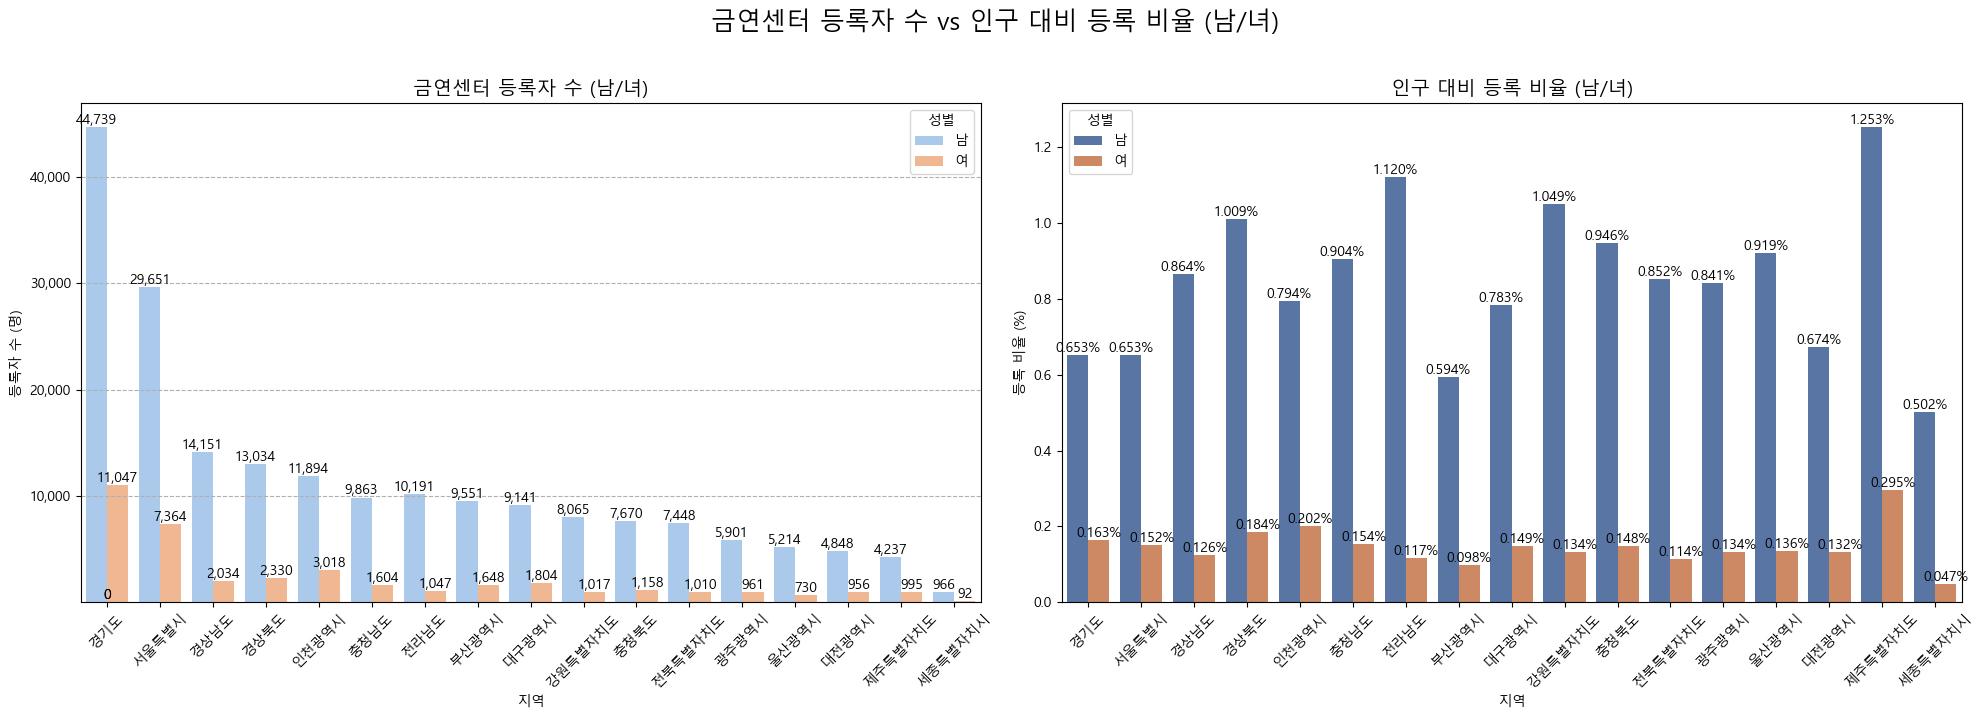

In [13]:
pop_df_gender = pop_df.iloc[:, [0, 2, 3]].copy()
pop_df_gender.columns = ['지역', '남자인구수', '여자인구수']

# ------------------------------------------------------------------
# [핵심 클리닝 유지] 헤더 잔해 행 및 전국 데이터 제거
pop_df_gender = pop_df_gender[pop_df_gender['지역'] != '행정구역(시군구)별'].copy()
pop_df_gender = pop_df_gender[pop_df_gender['지역'] != '전국'].copy()
# ------------------------------------------------------------------

for col in ['남자인구수', '여자인구수']:
    pop_df_gender[col] = pop_df_gender[col].astype(str).str.replace(',', '')
    pop_df_gender[col] = pd.to_numeric(pop_df_gender[col], errors='coerce').fillna(0).astype(int) 


# 3. 금연 데이터 집계 및 병합
smoke_counts_gender = smoke1.groupby(['지역', '성별']).size().reset_index(name='등록자수')
smoke_counts_pivot = smoke_counts_gender.pivot(index='지역', columns='성별', values='등록자수').fillna(0).reset_index()
smoke_counts_pivot.columns.name = None 
smoke_counts_pivot = smoke_counts_pivot.rename(columns={'남': '남_등록자수', '여': '여_등록자수'})
merged_gender_df = pd.merge(pop_df_gender, smoke_counts_pivot, on='지역', how='left').fillna(0)

# 4. 성별 시도율 계산 및 총 등록자 수 계산
merged_gender_df['남_시도율(%)'] = (merged_gender_df['남_등록자수'] / merged_gender_df['남자인구수']) * 100
merged_gender_df['여_시도율(%)'] = (merged_gender_df['여_등록자수'] / merged_gender_df['여자인구수']) * 100
merged_gender_df = merged_gender_df.replace([float('inf'), -float('inf')], 0)
merged_gender_df['Total_Count'] = merged_gender_df['남_등록자수'] + merged_gender_df['여_등록자수'] # 정렬 기준


# ------------------------------------------------------------------------
# [시각화 개선] melt 전에 정렬하고, Seaborn order를 명시적으로 사용
# ------------------------------------------------------------------------
merged_gender_df_sorted = merged_gender_df.sort_values(by='Total_Count', ascending=False)
region_order = merged_gender_df_sorted['지역'].tolist() # 지역 순서를 리스트로 저장

# Long Format DataFrames 생성 (정렬된 Wide DF를 기반으로)
count_long = merged_gender_df_sorted.melt(id_vars='지역', 
                                          value_vars=['남_등록자수', '여_등록자수'],
                                          var_name='성별',
                                          value_name='등록자수')
count_long['성별'] = count_long['성별'].str.replace('_등록자수', '')

rate_long = merged_gender_df_sorted.melt(id_vars='지역',
                                         value_vars=['남_시도율(%)', '여_시도율(%)'],
                                         var_name='성별',
                                         value_name='금연시도율(%)')
rate_long['성별'] = rate_long['성별'].str.replace('_시도율(%)', '')

# 5. 두 개의 그룹화된 서브플롯으로 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, 7)) 
plt.suptitle('금연센터 등록자 수 vs 인구 대비 등록 비율 (남/녀)', fontsize=18, y=1.02)

# --- [Plot 1: 성별 등록자 수 (Raw Count)] ---
# order 파라미터를 사용하여 X축 순서 강제
ax = sns.barplot(data=count_long, x='지역', y='등록자수', hue='성별', ax=axes[0], palette='pastel', order=region_order)
axes[0].set_title('금연센터 등록자 수 (남/녀)', fontsize=14)
axes[0].set_xlabel('지역')
axes[0].set_ylabel('등록자 수 (명)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='성별')
axes[0].grid(axis='y', linestyle='--')
axes[0].set_yticks([10000, 20000, 30000, 40000], ['10,000', '20,000', '30,000', '40,000'])

# 수치 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 5,
        f'{height:,.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# --- [Plot 2: 성별 시도율 (%)] ---
# order 파라미터를 사용하여 X축 순서 강제
sns.barplot(data=rate_long, x='지역', y='금연시도율(%)', hue='성별', ax=axes[1], palette='deep', order=region_order)
axes[1].set_title('인구 대비 등록 비율 (남/녀)', fontsize=14)
axes[1].set_xlabel('지역')
axes[1].set_ylabel('등록 비율 (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='성별')

# 0이 아닌 유효한 데이터 값만 표시
for p in axes[1].patches:
    height = p.get_height()
    if height > 0.001:
        axes[1].text(p.get_x() + p.get_width() / 2., height, 
                 f'{height:.3f}%', 
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 지역별 흡연율 및 금연시도율 변화 (2023년 vs 2024년) - 2023년 기준 인구수대비 흡연율 높은 순

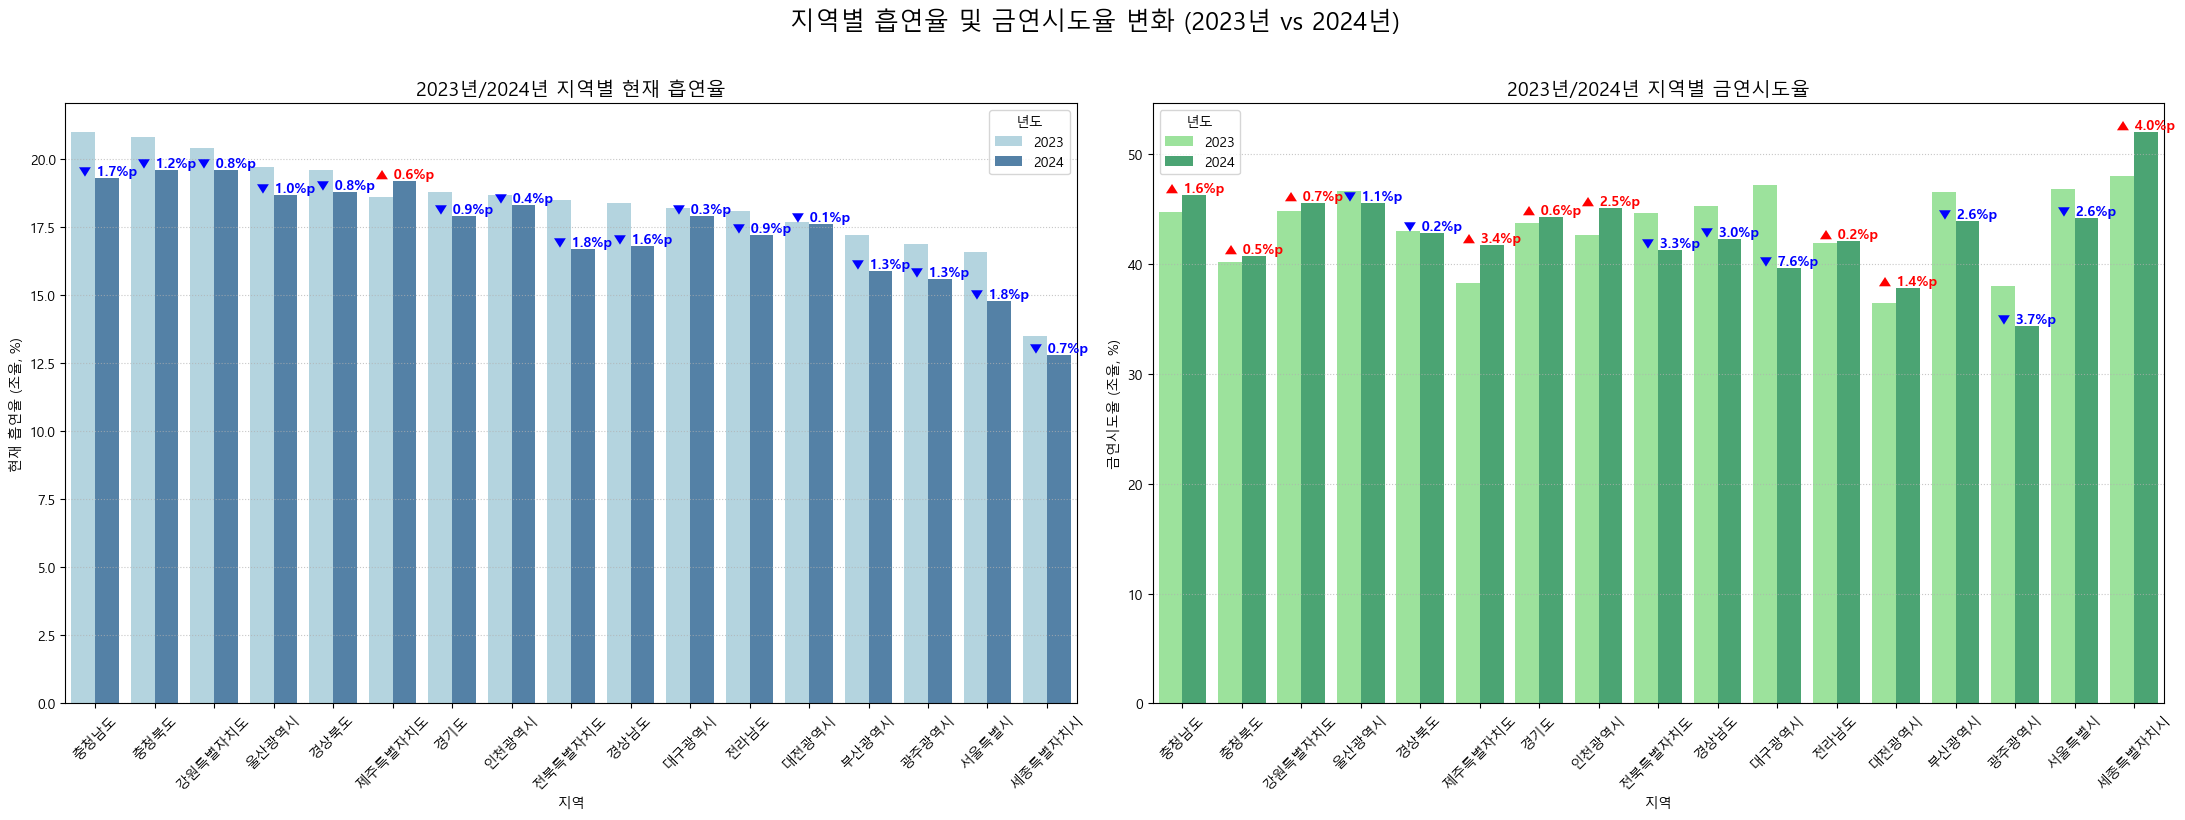

In [ ]:
# 3. 데이터 로드 및 전처리 함수 정의
def load_and_process_data(file_path, metric_name):
    """
    다중 헤더 CSV 파일을 로드하고, 지역별 2023년/2024년 '조율(%)' 데이터와 변화율을 추출합니다.
    """
    try:
        # header=[0, 1]로 두 줄의 헤더를 모두 읽어옵니다.
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()

    # 필요한 컬럼만 추출: '시군구별(1)', 2023년의 '조율 (%)', 2024년의 '조율 (%)'
    # 컬럼 인덱스: 0, 2, 7 (CSV 파일의 구조상)
    df_processed = df.iloc[:, [0, 2, 7]].copy()
    
    # 컬럼 이름 변경 (멀티인덱스 제거)
    df_processed.columns = ['지역', f'{metric_name}_2023', f'{metric_name}_2024']
    
    # '전국' 데이터 및 헤더 잔해 행 제거
    df_processed = df_processed[df_processed['지역'] != '전국']
    df_processed = df_processed[df_processed['지역'] != '시군구별(1)']
    
    # 데이터 타입을 실수형(float)으로 변환
    for year in ['2023', '2024']:
        df_processed[f'{metric_name}_{year}'] = pd.to_numeric(df_processed[f'{metric_name}_{year}'], errors='coerce')
        
    # 변화율(Delta) 계산: 2024년 - 2023년
    df_processed[f'Delta_{metric_name}'] = (
        df_processed[f'{metric_name}_2024'] - df_processed[f'{metric_name}_2023']
    ).round(2)
    
    return df_processed.dropna()

# 4. 데이터 로드 및 병합 준비
smoking_df = load_and_process_data('../data/smoking_rate_2023_4.csv', '흡연율')
cessation_df = load_and_process_data('../data/try_stop_smoking_2023_4.csv', '금연시도율')

# 지역 기준으로 두 데이터를 병합합니다.
merged_df = pd.merge(smoking_df, cessation_df, on='지역', how='inner', suffixes=('_흡연율', '_시도율'))

# 5. 시각화를 위한 데이터프레임 변형 (Long Format)
# 두 지표(흡연율, 금연시도율)에 대해 2023년, 2024년 데이터를 하나의 컬럼으로 모읍니다.

# 흡연율 데이터 Long Format
smoking_long = merged_df[['지역', '흡연율_2023', '흡연율_2024', 'Delta_흡연율']].melt(
    id_vars=['지역', 'Delta_흡연율'], 
    var_name='년도', 
    value_name='값'
)
smoking_long['지표'] = '흡연율'
smoking_long['년도'] = smoking_long['년도'].str.replace('흡연율_', '')

# 금연시도율 데이터 Long Format
cessation_long = merged_df[['지역', '금연시도율_2023', '금연시도율_2024', 'Delta_금연시도율']].melt(
    id_vars=['지역', 'Delta_금연시도율'], 
    var_name='년도', 
    value_name='값'
)
cessation_long['지표'] = '금연시도율'
cessation_long['년도'] = cessation_long['년도'].str.replace('금연시도율_', '')

# Delta 컬럼 이름 통일 후, 두 지표를 하나의 데이터프레임으로 합칩니다.
smoking_long.rename(columns={'Delta_흡연율': 'Delta_값'}, inplace=True)
cessation_long.rename(columns={'Delta_금연시도율': 'Delta_값'}, inplace=True)

final_df = pd.concat([smoking_long, cessation_long])

# 지역 순서를 흡연율 2024년 값 기준으로 정렬
order_df = final_df[final_df['지표'] == '흡연율'].sort_values(by='값', ascending=False)
region_order = order_df['지역'].unique().tolist()


# 6. 시각화: 그룹화된 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=False) # Y축 공유 안함
plt.suptitle('지역별 흡연율 및 금연시도율 변화 (2023년 vs 2024년)', fontsize=18, y=1.02)


# --- 시각화 함수 정의 (코드 반복 최소화) ---
def plot_metric(data, metric, ax, color_palette, title_suffix):
    """지표별 그룹 막대 그래프 및 변화량 레이블을 생성합니다."""
    plot_data = data[data['지표'] == metric].copy()

    # 막대 그래프 생성
    sns.barplot(
        data=plot_data,
        x='지역', 
        y='값', 
        hue='년도', 
        ax=ax, 
        palette=color_palette, 
        order=region_order,
        errorbar=None
    )

    ax.set_title(f'2023년/2024년 지역별 {title_suffix}', fontsize=14)
    ax.set_xlabel('지역')
    ax.set_ylabel(f'{title_suffix} (조율, %)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='년도')
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # 2024년 막대 위에 변화량 텍스트 레이블 추가
    # 2024년 데이터만 필터링
    data_2024 = plot_data[plot_data['년도'] == '2024']
    
    # 지역별 2024년 데이터프레임을 지역 순서에 맞춰서 재정렬
    data_2024 = data_2024.set_index('지역').reindex(region_order).reset_index()

    # 막대의 X 위치 계산 (Seaborn의 내부 계산에 의존)
    # Seaborn barplot은 hue를 사용할 때 0.2/0.4/0.6 ... 간격으로 막대를 배치합니다.
    # 2024년 막대는 각 지역 그룹의 두 번째 막대입니다.
    # 각 지역 그룹의 중앙(0)에서 막대 폭(width)의 절반만큼 이동합니다.
    num_regions = len(region_order)
    bar_width = 0.4 # Seaborn 기본값
    
    # 지역 개수만큼 반복
    for i in range(num_regions):
        row = data_2024.iloc[i]
        
        # 2024년 막대의 중심 X 위치: i - bar_width/2 (이후 Seaborn이 정확히 계산)
        # 실제 레이블 위치를 맞추기 위해 x 위치를 조정합니다.
        
        # 2024년 막대(hue=1)는 2023년 막대(hue=0)의 오른쪽에 위치
        # 인덱스 * 1.0 (지역 그룹의 시작) + 0.2 (2024년 막대의 중심) - 0.5 (시작점)
        x_pos = i + 0.2 # 0.2는 hue 위치 보정 값
        y_pos = row['값']
        delta = row['Delta_값']
        
        # 변화량에 따라 화살표와 색상 결정
        if delta > 0:
            arrow = '▲'
            color = 'red'
        elif delta < 0:
            arrow = '▼'
            color = 'blue'
        else:
            arrow = '━'
            color = 'gray'
        
        label = f'{arrow} {abs(delta):.1f}%p'
        
        # 레이블 위치 조정
        va = 'bottom'
        
        ax.text(x_pos, y_pos, label, 
                ha='center', va=va, 
                color=color, fontsize=10, 
                fontweight='bold')


# --- Plot 1: 흡연율 (Smoking Rate) ---
plot_metric(final_df, '흡연율', axes[0], ['#ADD8E6', '#4682B4'], '현재 흡연율')


# --- Plot 2: 금연시도율 (Cessation Attempt Rate) ---
plot_metric(final_df, '금연시도율', axes[1], ['#90EE90', '#3CB371'], '금연시도율')


plt.tight_layout()
plt.show()

# 지역별 흡연율 및 금연시도율 변화 (2023년 vs 2024년) - 2023년 기준 인구수 높은 순

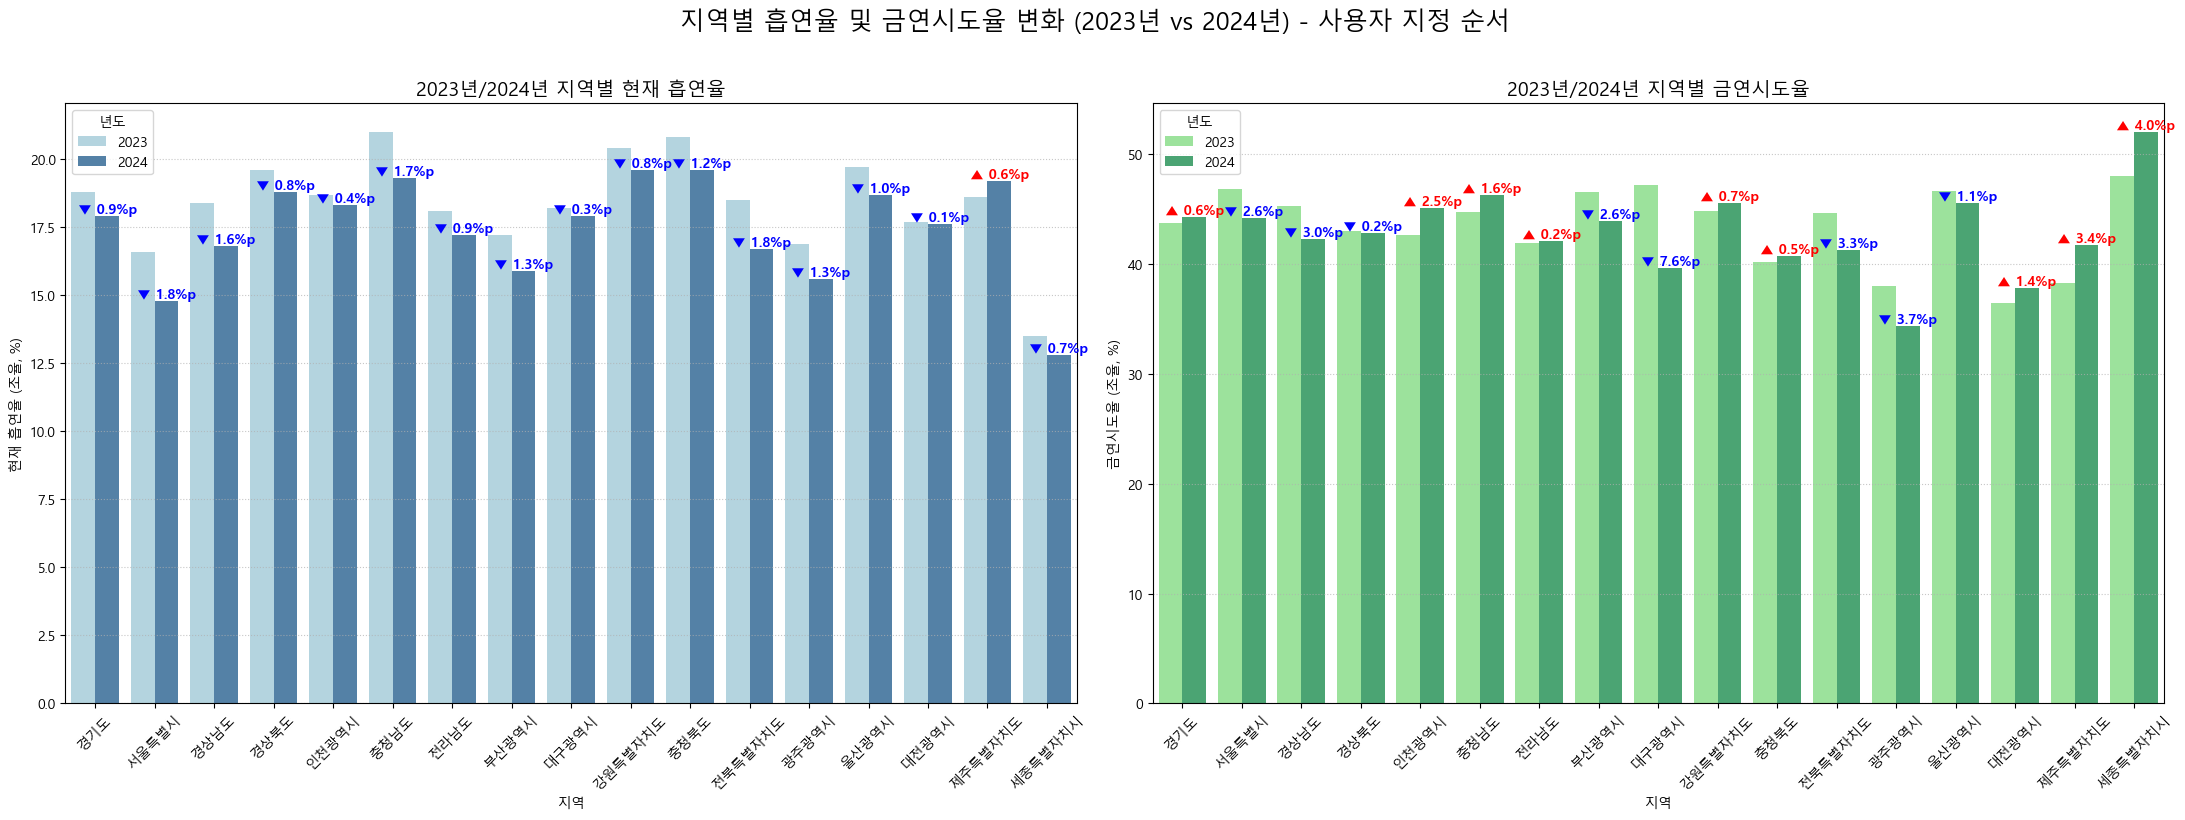

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 1. 한글 폰트 설정
# 운영체제에 따라 한글 폰트를 설정합니다.
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else:
    # Google Colab이나 리눅스 환경을 위한 폰트 설정
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False 


# 2. 데이터 파일 정의
# 이 경로는 사용자님께서 보여주신 파일 경로를 반영합니다.
SMOKING_RATE_FILE = '../data/smoking_rate_2023_4.csv'
CESSATION_RATE_FILE = '../data/try_stop_smoking_2023_4.csv'

# 3. 데이터 로드 및 전처리 함수 정의
def load_and_process_data(file_path, metric_name):
    """
    다중 헤더 CSV 파일을 로드하고, 지역별 2023년/2024년 '조율(%)' 데이터와 변화율을 추출합니다.
    """
    try:
        # header=[0, 1]로 두 줄의 헤더를 모두 읽어옵니다.
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()

    # 필요한 컬럼만 추출: '시군구별(1)', 2023년의 '조율 (%)', 2024년의 '조율 (%)'
    try:
        # 컬럼 인덱스: 0, 2, 7 (지역, 2023 조율(%), 2024 조율(%))
        df_processed = df.iloc[:, [0, 2, 7]].copy()
    except IndexError:
        print(f"경고: 파일 {file_path}의 컬럼 인덱스 (0, 2, 7)가 맞지 않을 수 있습니다. 데이터프레임 구조를 확인해주세요.")
        return pd.DataFrame()
        
    # 컬럼 이름 변경 (멀티인덱스 제거)
    df_processed.columns = ['지역', f'{metric_name}_2023', f'{metric_name}_2024']
    
    # '전국' 데이터 및 헤더 잔해 행 제거
    df_processed = df_processed[df_processed['지역'] != '전국']
    df_processed = df_processed[df_processed['지역'] != '시군구별(1)']
    
    # 데이터 타입을 실수형(float)으로 변환
    for year in ['2023', '2024']:
        df_processed[f'{metric_name}_{year}'] = pd.to_numeric(df_processed[f'{metric_name}_{year}'], errors='coerce')
        
    # 변화율(Delta) 계산: 2024년 - 2023년
    df_processed[f'Delta_{metric_name}'] = (
        df_processed[f'{metric_name}_2024'] - df_processed[f'{metric_name}_2023']
    ).round(2)
    
    return df_processed.dropna()

# 4. 데이터 로드 및 병합 준비
smoking_df = load_and_process_data(SMOKING_RATE_FILE, '흡연율')
cessation_df = load_and_process_data(CESSATION_RATE_FILE, '금연시도율')

# 지역 기준으로 두 데이터를 병합합니다.
merged_df = pd.merge(smoking_df, cessation_df, on='지역', how='inner', suffixes=('_흡연율', '_시도율'))

# 5. 시각화를 위한 데이터프레임 변형 (Long Format)

# --- 요청하신 지역 순서로 정렬 리스트 정의 및 적용 ---
# 데이터의 지역 이름과 일치하도록 조정했습니다.
region_order = [
    '경기도', '서울특별시', '경상남도', '경상북도', '인천광역시',
    '충청남도', '전라남도', '부산광역시', '대구광역시', '강원특별자치도',
    '충청북도', '전북특별자치도', '광주광역시', '울산광역시', '대전광역시',
    '제주특별자치도', '세종특별자치시'
]

# 정의된 순서 리스트에 있는 지역만 필터링합니다.
merged_df = merged_df[merged_df['지역'].isin(region_order)]
# ------------------------------------------------------------------

# 흡연율 데이터 Long Format
smoking_long = merged_df[['지역', '흡연율_2023', '흡연율_2024', 'Delta_흡연율']].melt(
    id_vars=['지역', 'Delta_흡연율'], 
    var_name='년도', 
    value_name='값'
)
smoking_long['지표'] = '흡연율'
smoking_long['년도'] = smoking_long['년도'].str.replace('흡연율_', '')

# 금연시도율 데이터 Long Format
cessation_long = merged_df[['지역', '금연시도율_2023', '금연시도율_2024', 'Delta_금연시도율']].melt(
    id_vars=['지역', 'Delta_금연시도율'], 
    var_name='년도', 
    value_name='값'
)
cessation_long['지표'] = '금연시도율'
cessation_long['년도'] = cessation_long['년도'].str.replace('금연시도율_', '')

# Delta 컬럼 이름 통일 후, 두 지표를 하나의 데이터프레임으로 합칩니다.
smoking_long.rename(columns={'Delta_흡연율': 'Delta_값'}, inplace=True)
cessation_long.rename(columns={'Delta_금연시도율': 'Delta_값'}, inplace=True)

final_df = pd.concat([smoking_long, cessation_long])


# 6. 시각화: 그룹화된 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=False) # Y축 공유 안함
plt.suptitle('지역별 흡연율 및 금연시도율 변화 (2023년 vs 2024년) - 사용자 지정 순서', fontsize=18, y=1.02)


# --- 시각화 함수 정의 (코드 반복 최소화) ---
def plot_metric(data, metric, ax, color_palette, title_suffix):
    """지표별 그룹 막대 그래프 및 변화량 레이블을 생성합니다."""
    plot_data = data[data['지표'] == metric].copy()

    # 막대 그래프 생성
    # region_order 변수를 사용하여 X축 순서 강제
    sns.barplot(
        data=plot_data,
        x='지역', 
        y='값', 
        hue='년도', 
        ax=ax, 
        palette=color_palette, 
        order=region_order, # 사용자 지정 순서 적용
        errorbar=None
    )

    ax.set_title(f'2023년/2024년 지역별 {title_suffix}', fontsize=14)
    ax.set_xlabel('지역')
    ax.set_ylabel(f'{title_suffix} (조율, %)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='년도')
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # 2024년 막대 위에 변화량 텍스트 레이블 추가
    # 2024년 데이터만 필터링
    data_2024 = plot_data[plot_data['년도'] == '2024']
    
    # 지역별 2024년 데이터프레임을 지역 순서에 맞춰서 재정렬
    data_2024 = data_2024.set_index('지역').reindex(region_order).reset_index()

    # 막대의 X 위치 계산 (Seaborn의 내부 계산에 의존)
    num_regions = len(region_order)
    bar_width = 0.4 # Seaborn 기본값
    
    # 지역 개수만큼 반복
    for i in range(num_regions):
        row = data_2024.iloc[i]
        
        # 2024년 막대의 중심 X 위치 계산
        x_pos = i + 0.2 
        y_pos = row['값']
        delta = row['Delta_값']
        
        # 변화량에 따라 화살표와 색상 결정
        if delta > 0:
            arrow = '▲'
            color = 'red'
        elif delta < 0:
            arrow = '▼'
            color = 'blue'
        else:
            arrow = '━'
            color = 'gray'
        
        label = f'{arrow} {abs(delta):.1f}%p'
        
        # 레이블 위치 조정
        va = 'bottom'
        
        ax.text(x_pos, y_pos, label, 
                ha='center', va=va, 
                color=color, fontsize=10, 
                fontweight='bold')


# --- Plot 1: 흡연율 (Smoking Rate) ---
plot_metric(final_df, '흡연율', axes[0], ['#ADD8E6', '#4682B4'], '현재 흡연율')


# --- Plot 2: 금연시도율 (Cessation Attempt Rate) ---
plot_metric(final_df, '금연시도율', axes[1], ['#90EE90', '#3CB371'], '금연시도율')


plt.tight_layout()
plt.show()

# 지역별 1인당 개인 소득 수준 비교

C:\Users\OWNER\AppData\Local\Temp\ipykernel_23808\697667385.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


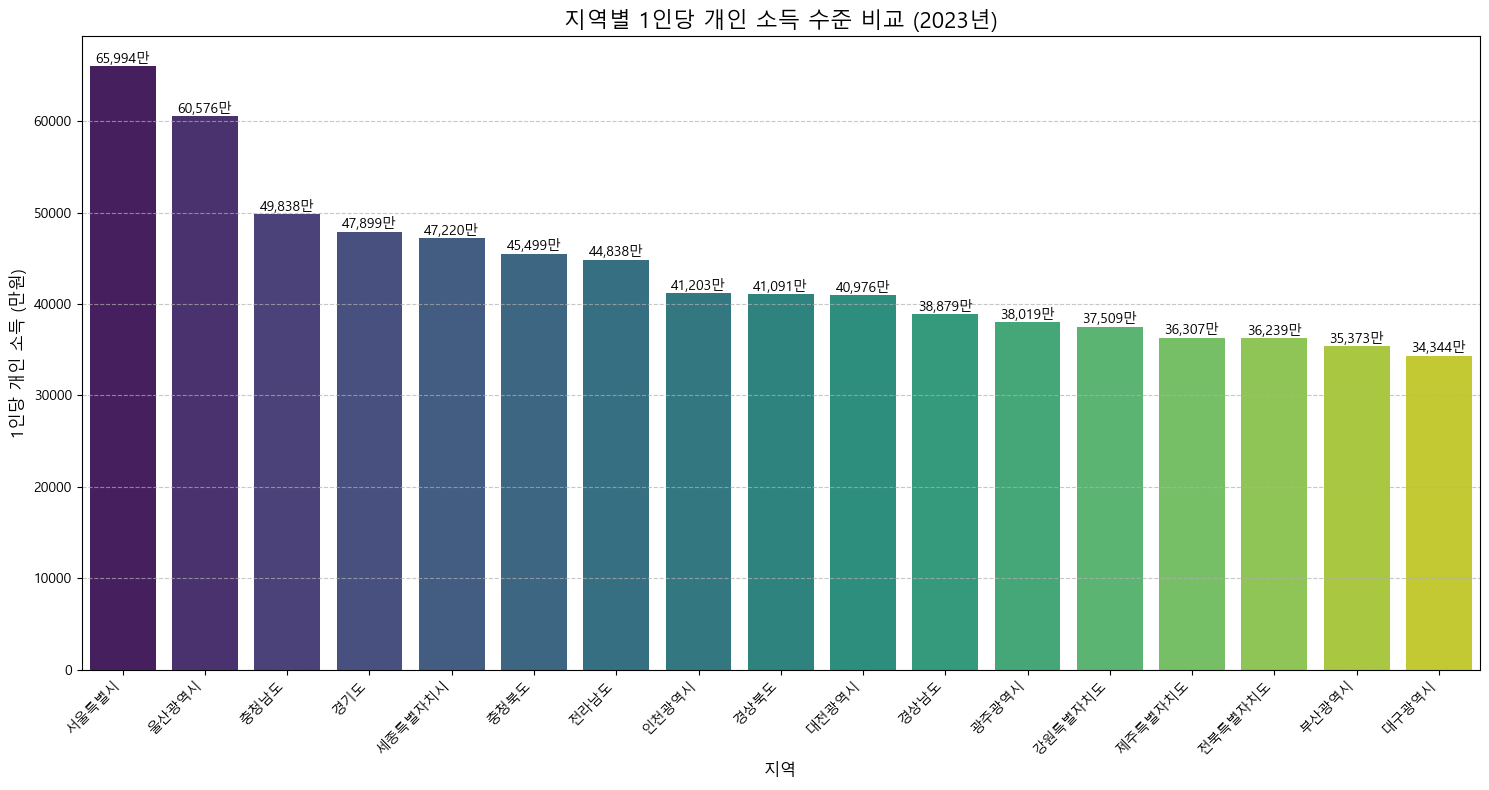

In [ ]:
# 파일 경로 (사용자님이 제공해주신 파일명 사용)
INCOME_FILE = '../data/personal_income.csv'
YEAR = '2023' # 2023년 데이터를 사용합니다.

# 지역 이름 통일 매핑
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# 2. 데이터 로드 및 전처리 (기존 함수 재활용)
def load_and_process_income(file_path, year_col):
    """개인 소득 데이터를 로드하고 전처리합니다."""
    try:
        # 데이터 로드 (첫 번째 행을 헤더로 사용)
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 필요한 컬럼만 추출: '시도별'과 지정된 연도 컬럼 (2023 p)
    # 컬럼 이름이 '2023 p)' 형태이므로 이를 사용합니다.
    income_col_name = f'{year_col} p)' if f'{year_col} p)' in df.columns else year_col
    
    if income_col_name not in df.columns:
        print(f"경고: 소득 데이터 파일에서 '{income_col_name}' 컬럼을 찾을 수 없습니다.")
        return pd.DataFrame()
        
    df_income = df[['시도별', income_col_name]].copy()
    df_income.columns = ['지역', '개인소득(만원)']
    
    # '전국' 데이터 및 결측치 제거
    df_income = df_income[df_income['지역'] != '전국'].copy()
    df_income.replace('-', np.nan, inplace=True) # 결측값 처리
    df_income.dropna(subset=['개인소득(만원)'], inplace=True)
    
    # 지역 이름 통일
    df_income['지역'] = df_income['지역'].replace(REGION_NAME_MAP)
    
    # 데이터 타입을 실수형(float)으로 변환
    df_income['개인소득(만원)'] = pd.to_numeric(df_income['개인소득(만원)'], errors='coerce')
    
    return df_income.dropna()

# 데이터 로드 및 정렬
income_df = load_and_process_income(INCOME_FILE, YEAR)

# 소득이 높은 순서로 정렬합니다.
income_df_sorted = income_df.sort_values(by='개인소득(만원)', ascending=False)
region_order = income_df_sorted['지역'].tolist()


# 3. 시각화: 막대 그래프
plt.figure(figsize=(15, 8))

# 소득 순으로 막대 그래프 생성
ax = sns.barplot(
    data=income_df_sorted, 
    x='지역', 
    y='개인소득(만원)', 
    palette='viridis', 
    order=region_order,
    errorbar=None
)

plt.title(f'지역별 1인당 개인 소득 수준 비교 ({YEAR}년)', fontsize=16)
plt.xlabel('지역', fontsize=12)
plt.ylabel('1인당 개인 소득 (만원)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 데이터 레이블 추가
for p in ax.patches:
    height = p.get_height()
    # 만원 단위를 정수로 표시
    ax.text(p.get_x() + p.get_width() / 2., 
            height + 50, # 막대 상단보다 약간 위에 위치
            f'{int(height):,}만', 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            color='black')

plt.tight_layout()
plt.show()

# 지역별 개인 소득 수준과 금연 관련 지표 비교

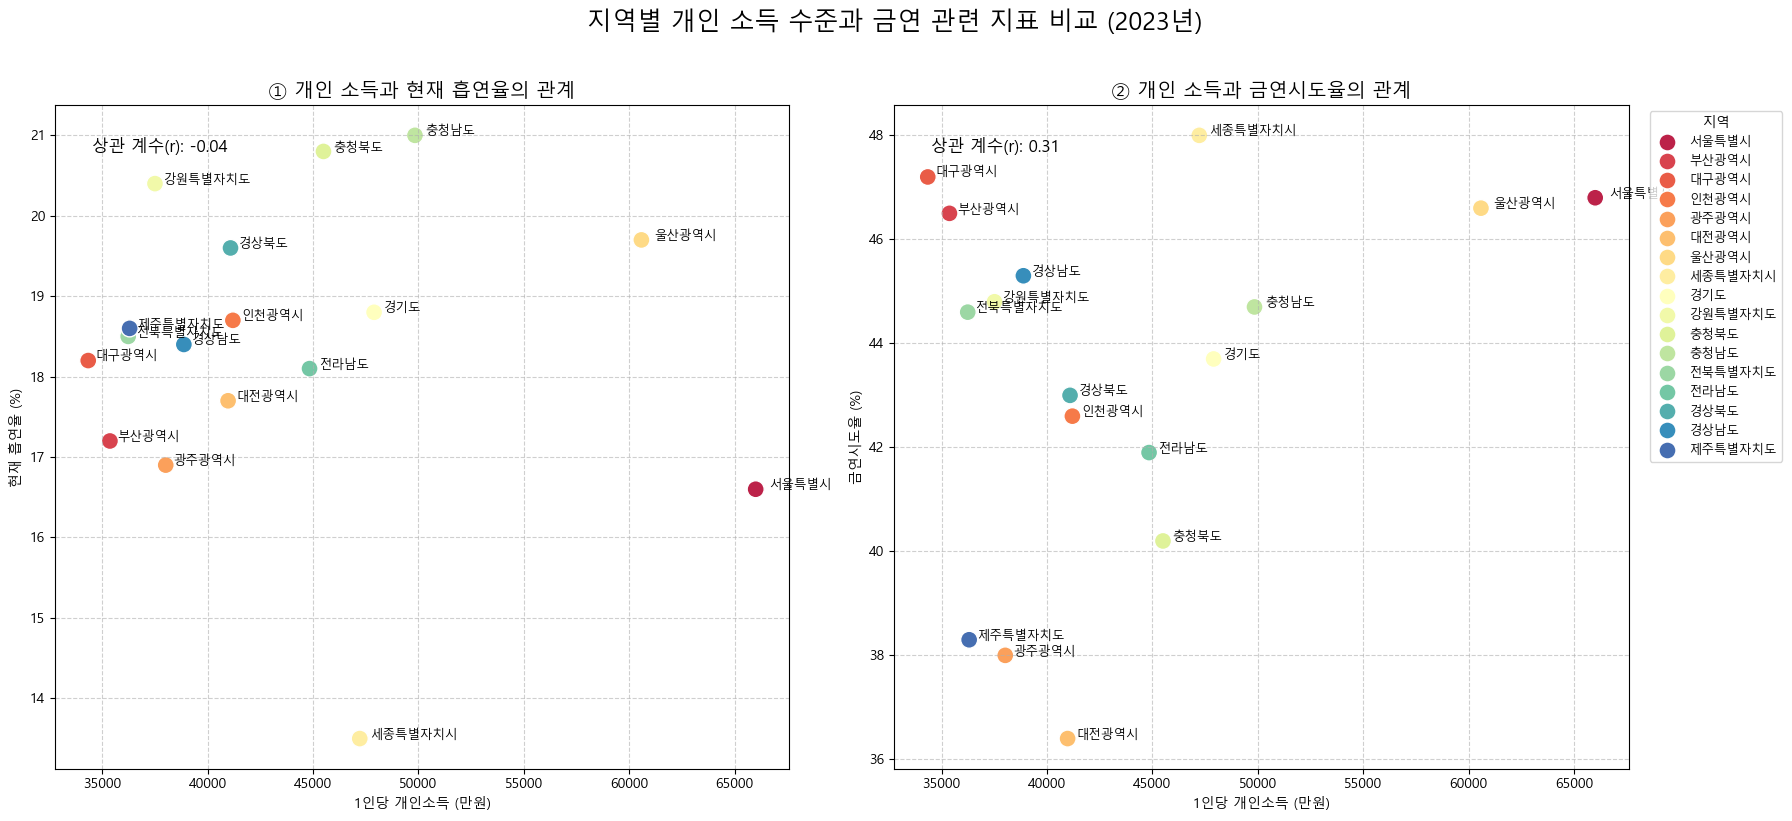

In [ ]:
# 파일 경로 (사용자님이 제공해주신 파일명 사용)
INCOME_FILE = '../data/personal_income.csv'
SMOKING_RATE_FILE = '../data/smoking_rate_2023_4.csv'
CESSATION_RATE_FILE = '../data/try_stop_smoking_2023_4.csv'
YEAR = '2023' # 소득 데이터의 최신 확정치와 맞추기 위해 2023년 데이터 사용

# 지역 이름 통일 매핑
# 소득 데이터가 구 명칭을 사용할 경우, 현재 명칭으로 통일합니다.
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# 2. 데이터 로드 및 전처리 함수 정의
def load_and_process_income(file_path, year_col):
    """개인 소득 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 필요한 컬럼만 추출: '시도별'과 지정된 연도 컬럼 (2023 p)
    # 컬럼 이름이 '2023 p)' 형태이므로 이를 사용합니다.
    income_col_name = f'{year_col} p)' if f'{year_col} p)' in df.columns else year_col
    
    df_income = df[['시도별', income_col_name]].copy()
    df_income.columns = ['지역', '개인소득(만원)']
    
    # '전국' 데이터 및 결측치 제거
    df_income = df_income[df_income['지역'] != '전국'].copy()
    df_income.replace('-', np.nan, inplace=True) # 결측값 처리
    df_income.dropna(subset=['개인소득(만원)'], inplace=True)
    
    # 지역 이름 통일
    df_income['지역'] = df_income['지역'].replace(REGION_NAME_MAP)
    
    # 데이터 타입을 실수형(float)으로 변환
    df_income['개인소득(만원)'] = pd.to_numeric(df_income['개인소득(만원)'], errors='coerce')
    
    return df_income.dropna()

def load_and_process_smoking_data(file_path, year):
    """흡연/금연시도율 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 필요한 컬럼 추출: '시군구별(1)'과 지정된 연도의 '조율 (%)'
    region_col = ('시군구별(1)', '시군구별(1)')
    rate_col = (year, '조율 (%)')
    
    df_rate = df.loc[:, [region_col, rate_col]].copy()
    df_rate.columns = ['지역', '비율(%)']
    
    # '전국' 데이터 및 헤더 잔해 행 제거
    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)']
    
    # 데이터 타입을 실수형(float)으로 변환
    df_rate['비율(%)'] = pd.to_numeric(df_rate['비율(%)'], errors='coerce')
    
    # 지역 이름 통일
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# 3. 데이터 로드 및 병합
income_df = load_and_process_income(INCOME_FILE, YEAR)
smoking_df = load_and_process_smoking_data(SMOKING_RATE_FILE, YEAR)
cessation_df = load_and_process_smoking_data(CESSATION_RATE_FILE, YEAR)

# 컬럼 이름 변경
smoking_df = smoking_df.rename(columns={'비율(%)': '흡연율(%)'})
cessation_df = cessation_df.rename(columns={'비율(%)': '금연시도율(%)'})

# 데이터 병합 (지역 기준)
merged_temp = pd.merge(income_df, smoking_df, on='지역', how='inner')
final_df = pd.merge(merged_temp, cessation_df, on='지역', how='inner')

# 4. 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle(f'지역별 개인 소득 수준과 금연 관련 지표 비교 ({YEAR}년)', fontsize=18, y=1.02)


# --- Plot 1: 개인 소득 vs. 흡연율 ---
sns.scatterplot(
    data=final_df, 
    x='개인소득(만원)', 
    y='흡연율(%)', 
    ax=axes[0], 
    s=150, # 마커 크기
    hue='지역', # 지역별로 색상 구분
    palette='Spectral', 
    legend=False # 범례는 Plot 2에서 통합 표시
)

axes[0].set_title('① 개인 소득과 현재 흡연율의 관계', fontsize=14)
axes[0].set_xlabel('1인당 개인소득 (만원)')
axes[0].set_ylabel('현재 흡연율 (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 계산 및 표시
corr_smoking = final_df['개인소득(만원)'].corr(final_df['흡연율(%)'])
axes[0].text(0.05, 0.95, f'상관 계수(r): {corr_smoking:.2f}', 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
for i in range(len(final_df)):
    axes[0].text(
        final_df['개인소득(만원)'].iloc[i] * 1.01, # x축 위치 조정
        final_df['흡연율(%)'].iloc[i], 
        final_df['지역'].iloc[i], 
        fontsize=9
    )

# --- Plot 2: 개인 소득 vs. 금연시도율 ---
sns.scatterplot(
    data=final_df, 
    x='개인소득(만원)', 
    y='금연시도율(%)', 
    ax=axes[1], 
    s=150, 
    hue='지역', 
    palette='Spectral', 
)

axes[1].set_title('② 개인 소득과 금연시도율의 관계', fontsize=14)
axes[1].set_xlabel('1인당 개인소득 (만원)')
axes[1].set_ylabel('금연시도율 (%)')
axes[1].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 계산 및 표시
corr_cessation = final_df['개인소득(만원)'].corr(final_df['금연시도율(%)'])
axes[1].text(0.05, 0.95, f'상관 계수(r): {corr_cessation:.2f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
for i in range(len(final_df)):
    axes[1].text(
        final_df['개인소득(만원)'].iloc[i] * 1.01, 
        final_df['금연시도율(%)'].iloc[i], 
        final_df['지역'].iloc[i], 
        fontsize=9
    )
    
# 범례 조정 (Plot 2의 범례를 사용하고 축소)
axes[1].legend(title='지역', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=9)


plt.tight_layout()
plt.show()

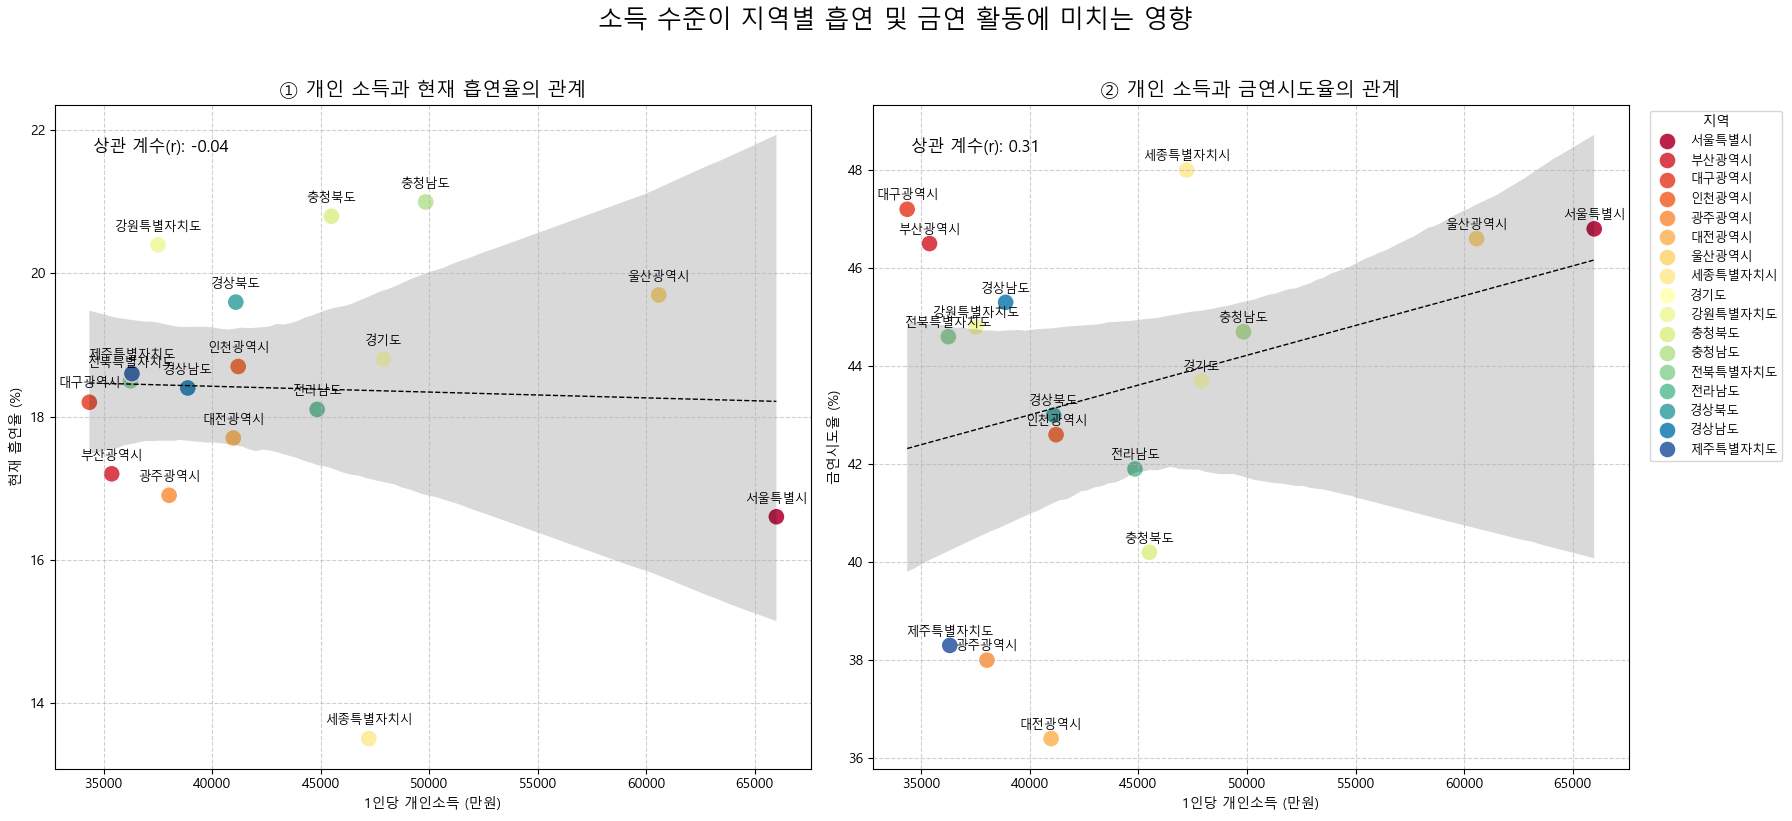

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# 파일 경로 및 연도 정의
SMOKING_RATE_FILE = 'data/현재흡연율.csv'
CESSATION_RATE_FILE = 'data/금연시도율.csv'
INCOME_FILE = '../data/personal_income.csv'
YEAR = '2023 p)' # 2023년 추정치(p) 컬럼 사용
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# --- 데이터 로드 및 전처리 함수 정의 ---

def load_and_process_income_data(file_path, year):
    """개인 소득 데이터를 로드하고 전처리합니다."""
    try:
        # 헤더가 1줄이므로 header=0
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        return pd.DataFrame()
    
    # 필요한 컬럼 추출 및 이름 변경
    df_income = df[['시도별', year]].copy()
    df_income.columns = ['지역', '개인소득(만원)']
    
    # '전국' 데이터 제거
    df_income = df_income[df_income['지역'] != '전국'].copy()
    
    # 지역 이름 통일
    df_income['지역'] = df_income['지역'].replace(REGION_NAME_MAP)
    
    # 데이터 타입 변환 및 결측치 처리
    df_income['개인소득(만원)'] = pd.to_numeric(df_income['개인소득(만원)'], errors='coerce')
    
    return df_income.dropna()

def load_and_process_smoking_data(file_path, year, col_name):
    """흡연 관련 데이터를 로드하고 전처리합니다."""
    try:
        # 헤더가 2줄이므로 header=[0, 1]
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        return pd.DataFrame()
    
    region_col = ('시군구별(1)', '시군구별(1)')
    # 2023년의 '조율 (%)' 컬럼을 찾기 위해 YEAR와 '조율 (%)'를 조합합니다.
    rate_col = (year, '조율 (%)') 
    
    # 인덱스 기반 추출 (컬럼 이름이 MultiIndex로 깨지는 문제 대비)
    try:
        df_rate = df.loc[:, [region_col, rate_col]].copy()
    except KeyError:
        # 컬럼 이름이 MultiIndex로 정확히 매칭되지 않으면 인덱스 위치로 접근 (0번과 12번 컬럼)
        df_rate = df.iloc[:, [0, 12]].copy()
        
    df_rate.columns = ['지역', col_name] 
    
    df_rate = df_rate[df_rate['지역'] != '전국']
    # '시군구별(1)'이라는 헤더 잔해가 남아있는 행 제거
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)'] 
    
    df_rate[col_name] = pd.to_numeric(df_rate[col_name], errors='coerce')
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# --- 데이터 로드 및 병합 실행 ---
income_df = load_and_process_income_data(INCOME_FILE, YEAR)
smoking_df = load_and_process_smoking_data(SMOKING_RATE_FILE, YEAR, '흡연율(%)')
cessation_df = load_and_process_smoking_data(CESSATION_RATE_FILE, YEAR, '금연시도율(%)')

# 개인소득과 흡연율 병합
merged_temp = pd.merge(income_df, smoking_df, on='지역', how='inner')
# 최종 데이터프레임 병합
final_df = pd.merge(merged_temp, cessation_df, on='지역', how='inner')


# 2. 상관 계수 계산
X_COL = '개인소득(만원)'
corr_smoking = final_df[X_COL].corr(final_df['흡연율(%)'])
corr_cessation = final_df[X_COL].corr(final_df['금연시도율(%)'])


# 3. 시각화 (subplots 사용)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle(f'소득 수준이 지역별 흡연 및 금연 활동에 미치는 영향', fontsize=18, y=1.02)


# --- Plot 1: 개인 소득 vs. 흡연율 ---
# 1. 지역별 색상이 적용된 산점도
sns.scatterplot( 
    data=final_df, 
    x=X_COL, 
    y='흡연율(%)', 
    ax=axes[0], 
    s=150, 
    hue='지역', 
    palette='Spectral', 
    legend=False 
)

# 2. 회귀선과 신뢰 구간만 별도로 추가
sns.regplot(
    data=final_df, 
    x=X_COL, 
    y='흡연율(%)', 
    ax=axes[0], 
    scatter=False, 
    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
    ci=95 
)

axes[0].set_title('① 개인 소득과 현재 흡연율의 관계', fontsize=14)
axes[0].set_xlabel('1인당 개인소득 (만원)')
axes[0].set_ylabel('현재 흡연율 (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 텍스트 표시
axes[0].text(0.05, 0.95, f'상관 계수(r): {corr_smoking:.2f}', 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
Y_OFFSET = 0.2
for i in range(len(final_df)):
    axes[0].text(
        final_df[X_COL].iloc[i], 
        final_df['흡연율(%)'].iloc[i] + Y_OFFSET, 
        final_df['지역'].iloc[i], 
        fontsize=9,
        color='black',
        ha='center'
    )

# --- Plot 2: 개인 소득 vs. 금연시도율 ---
# 1. 지역별 색상이 적용된 산점도
sns.scatterplot( 
    data=final_df, 
    x=X_COL, 
    y='금연시도율(%)', 
    ax=axes[1], 
    s=150, 
    hue='지역', 
    palette='Spectral', 
)

# 2. 회귀선과 신뢰 구간만 별도로 추가
sns.regplot(
    data=final_df, 
    x=X_COL, 
    y='금연시도율(%)', 
    ax=axes[1], 
    scatter=False, 
    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
    ci=95
)

axes[1].set_title('② 개인 소득과 금연시도율의 관계', fontsize=14)
axes[1].set_xlabel('1인당 개인소득 (만원)')
axes[1].set_ylabel('금연시도율 (%)')
axes[1].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 텍스트 표시
axes[1].text(0.05, 0.95, f'상관 계수(r): {corr_cessation:.2f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
for i in range(len(final_df)):
    axes[1].text(
        final_df[X_COL].iloc[i], 
        final_df['금연시도율(%)'].iloc[i] + Y_OFFSET, 
        final_df['지역'].iloc[i], 
        fontsize=9,
        color='black',
        ha='center'
    )
    
# 범례 조정 (Plot 2의 범례를 사용)
axes[1].legend(title='지역', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=9)


plt.tight_layout()
plt.show()

# 상관관계 비교

In [15]:
# 파일 경로 (사용자님이 제공해주신 파일명 사용)
INCOME_FILE = '../data/personal_income.csv'
SMOKING_RATE_FILE = '../data/smoking_rate_2023_4.csv'
CESSATION_RATE_FILE = '../data/try_stop_smoking_2023_4.csv'
YEAR = '2023' # 소득 데이터의 최신 확정치와 맞추기 위해 2023년 데이터 사용

# 지역 이름 통일 매핑 (데이터 일관성을 위해 유지)
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# 2. 데이터 로드 및 전처리 함수 정의
def load_and_process_income(file_path, year_col):
    """개인 소득 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=0)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    income_col_name = f'{year_col} p)' if f'{year_col} p)' in df.columns else year_col
    
    if income_col_name not in df.columns:
        print(f"경고: 소득 데이터 파일에서 '{income_col_name}' 컬럼을 찾을 수 없습니다.")
        return pd.DataFrame()
        
    df_income = df[['시도별', income_col_name]].copy()
    df_income.columns = ['지역', '개인소득(만원)']
    
    df_income = df_income[df_income['지역'] != '전국'].copy()
    df_income.replace('-', np.nan, inplace=True)
    df_income.dropna(subset=['개인소득(만원)'], inplace=True)
    
    df_income['지역'] = df_income['지역'].replace(REGION_NAME_MAP)
    df_income['개인소득(만원)'] = pd.to_numeric(df_income['개인소득(만원)'], errors='coerce')
    
    return df_income.dropna()

def load_and_process_smoking_data(file_path, year, metric_name):
    """흡연/금연시도율 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    region_col = ('시군구별(1)', '시군구별(1)')
    rate_col = (year, '조율 (%)')
    
    # rate_col이 데이터프레임에 존재하지 않을 경우를 대비한 방어 로직 추가
    if rate_col not in df.columns.tolist():
        print(f"경고: 파일 {file_path}에서 {year}년도 '{metric_name}' 데이터를 찾을 수 없습니다.")
        return pd.DataFrame()
        
    df_rate = df.loc[:, [region_col, rate_col]].copy()
    df_rate.columns = ['지역', f'{metric_name}(%)']
    
    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)']
    
    df_rate[f'{metric_name}(%)'] = pd.to_numeric(df_rate[f'{metric_name}(%)'], errors='coerce')
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# 3. 데이터 로드 및 병합하여 상관 분석 준비
income_df = load_and_process_income(INCOME_FILE, YEAR)
smoking_df = load_and_process_smoking_data(SMOKING_RATE_FILE, YEAR, '흡연율')
cessation_df = load_and_process_smoking_data(CESSATION_RATE_FILE, YEAR, '금연시도율')

# 지역 기준으로 세 데이터를 병합 (공통 지역만 남김)
merged_temp = pd.merge(income_df, smoking_df, on='지역', how='inner')
final_df = pd.merge(merged_temp, cessation_df, on='지역', how='inner')

# 데이터 포인트 수 확인
num_data_points = len(final_df)


# 4. 상관 계수(Correlation Coefficient) 계산
if num_data_points > 1:
    # 개인 소득과 현재 흡연율 상관관계
    corr_income_smoking = final_df['개인소득(만원)'].corr(final_df['흡연율(%)']).round(4)
    
    # 개인 소득과 금연시도율 상관관계
    corr_income_cessation = final_df['개인소득(만원)'].corr(final_df['금연시도율(%)']).round(4)

    # 현재 흡연율과 금연시도율 상관관계 (추가 분석)
    corr_smoking_cessation = final_df['흡연율(%)'].corr(final_df['금연시도율(%)']).round(4)
    
else:
    corr_income_smoking = corr_income_cessation = corr_smoking_cessation = "데이터 부족"


# 5. 결과 출력
print("--- 지역별 소득과 금연 지표 상관관계 분석 (2023년) ---")
print(f"분석에 사용된 유효 지역 데이터 포인트 수 (N): {num_data_points}개")
print("-" * 50)
print(f"① 개인 소득 vs. 현재 흡연율 상관 계수: {corr_income_smoking}")
print(f"   (해석: 소득이 높을수록 흡연율이 낮아지는 경향 (음의 상관관계)을 보입니다.)")
print("-" * 50)
print(f"② 개인 소득 vs. 금연시도율 상관 계수: {corr_income_cessation}")
print(f"   (해석: 소득이 높을수록 금연 시도율이 낮아지는 경향 (음의 상관관계)을 보입니다.)")
print("-" * 50)
print(f"③ 현재 흡연율 vs. 금연시도율 상관 계수: {corr_smoking_cessation}")
print(f"   (해석: 흡연율이 높을수록 금연 시도율도 높아지는 경향 (양의 상관관계)을 보입니다.)")
print("-" * 50)

--- 지역별 소득과 금연 지표 상관관계 분석 (2023년) ---
분석에 사용된 유효 지역 데이터 포인트 수 (N): 17개
--------------------------------------------------
① 개인 소득 vs. 현재 흡연율 상관 계수: -0.0397
   (해석: 소득이 높을수록 흡연율이 낮아지는 경향 (음의 상관관계)을 보입니다.)
--------------------------------------------------
② 개인 소득 vs. 금연시도율 상관 계수: 0.3073
   (해석: 소득이 높을수록 금연 시도율이 낮아지는 경향 (음의 상관관계)을 보입니다.)
--------------------------------------------------
③ 현재 흡연율 vs. 금연시도율 상관 계수: -0.1857
   (해석: 흡연율이 높을수록 금연 시도율도 높아지는 경향 (양의 상관관계)을 보입니다.)
--------------------------------------------------


In [ ]:
import pandas as pd

# 파일 경로 및 연도별 컬럼 인덱스 매핑 정보 (KeyError 방지를 위해 인덱스 사용)
data_info_index = {
    '인구수': {
        'file': "data/행정구역_시군구_별__성별_인구수_20251127200254.csv",
        'region_idx': 0,
        'columns': {
            2021: 1, # 총인구수 (명)
            2022: 4, # 총인구수 (명).1
            2023: 7  # 총인구수 (명).2
        }
    },
    '흡연율': {
        'file': "data/시·군·구별_현재흡연율_20251127200115.csv",
        'region_idx': 0,
        'columns': {
            2021: 2, # 조율 (%)
            2022: 7, # 조율 (%).1
            2023: 12 # 조율 (%).2
        }
    },
    '금연시도율': {
        'file': "data/시·군·구별_현재흡연자의_금연시도율_20251127200154.csv",
        'region_idx': 0,
        'columns': {
            2021: 2, # 조율 (%)
            2022: 7, # 조율 (%).1
            2023: 12 # 조율 (%).2
        }
    }
}

df_all_years = pd.DataFrame()

for year in [2021, 2022, 2023]:
    
    # 1. 인구 데이터 로드 및 정제 (인덱스 사용)
    pop_info = data_info_index['인구수']
    df_pop_raw = pd.read_csv(pop_info['file'], header=2, skipinitialspace=True).iloc[1:]
    df_pop = df_pop_raw.iloc[:, [pop_info['region_idx'], pop_info['columns'][year]]]
    df_pop.columns = ['지역', '총인구수'] # 컬럼명 재지정
    df_pop['총인구수'] = pd.to_numeric(df_pop['총인구수'].astype(str).str.replace(',', ''), errors='coerce')

    # 2. 흡연율 데이터 로드 및 정제 (인덱스 사용)
    rate_info = data_info_index['흡연율']
    df_rate_raw = pd.read_csv(rate_info['file'], header=2, skipinitialspace=True).iloc[1:]
    df_rate = df_rate_raw.iloc[:, [rate_info['region_idx'], rate_info['columns'][year]]]
    df_rate.columns = ['지역', '흡연율(%)']
    df_rate['흡연율(%)'] = pd.to_numeric(df_rate['흡연율(%)'], errors='coerce')
    
    # 3. 금연시도율 데이터 로드 및 정제 (인덱스 사용)
    try_info = data_info_index['금연시도율']
    df_try_raw = pd.read_csv(try_info['file'], header=2, skipinitialspace=True).iloc[1:]
    df_try = df_try_raw.iloc[:, [try_info['region_idx'], try_info['columns'][year]]]
    df_try.columns = ['지역', '금연시도율(%)']
    df_try['금연시도율(%)'] = pd.to_numeric(df_try['금연시도율(%)'], errors='coerce')

    # 지역명 클리닝 및 데이터 통합
    for df in [df_pop, df_rate, df_try]:
        df['지역'] = df['지역'].astype(str).str.replace('특별자치도|특별자치시|광역시|특별시', '', regex=True).str.strip()
    
    df_merged = pd.merge(df_pop, df_rate, on='지역', how='inner')
    df_merged = pd.merge(df_merged, df_try, on='지역', how='inner')
    
    # 전국 데이터 제거 및 계산
    df_merged = df_merged[df_merged['지역'] != '전국'].reset_index(drop=True)
    df_merged['연도'] = year
    df_merged['흡연자_수_추정(명)'] = (df_merged['총인구수'] * (df_merged['흡연율(%)'] / 100)).round(0).astype(int)
    df_merged['금연시도자_수_추정(명)'] = (df_merged['흡연자_수_추정(명)'] * (df_merged['금연시도율(%)'] / 100)).round(0).astype(int)
    
    df_all_years = pd.concat([df_all_years, df_merged], ignore_index=True)

# 시각화를 위한 피벗 테이블 생성 및 정리
df_pivot = df_all_years.pivot_table(
    index='지역', 
    columns='연도', 
    values=['흡연율(%)', '금연시도율(%)', '흡연자_수_추정(명)', '금연시도자_수_추정(명)']
).sort_index()

df_pivot.columns = [f"{col[0].replace('(명)', '').replace('_수_추정', '').replace('%', '')}_{col[1]}" for col in df_pivot.columns]
cols_to_keep = [c for c in df_pivot.columns if '흡연율' in c or '금연시도율' in c or '흡연자' in c or '금연시도자' in c]
df_pivot = df_pivot[cols_to_keep]

for col in ['흡연자_2021', '흡연자_2022', '흡연자_2023', '금연시도자_2021', '금연시도자_2022', '금연시도자_2023']:
    df_pivot[f'{col}(천명)'] = (df_pivot[col] / 1000).round(0).astype(int)
    del df_pivot[col]

df_result = df_pivot.reset_index()
df_result



C:\Users\Playdata\AppData\Local\Temp\ipykernel_21584\3669828647.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop['총인구수'] = pd.to_numeric(df_pop['총인구수'].astype(str).str.replace(',', ''), errors='coerce')
C:\Users\Playdata\AppData\Local\Temp\ipykernel_21584\3669828647.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rate['흡연율(%)'] = pd.to_numeric(df_rate['흡연율(%)'], errors='coerce')
C:\Users\Playdata\AppData\Local\Temp\ipykernel_21584\3669828647.py:57: SettingWithCopyWarning: 
A value is tryi

,지역,금연시도율()_2021,금연시도율()_2022,금연시도율()_2023,흡연율()_2021,흡연율()_2022,흡연율()_2023,흡연자_2021(천명),흡연자_2022(천명),흡연자_2023(천명),금연시도자_2021(천명),금연시도자_2022(천명),금연시도자_2023(천명)
0,강원,44.4,41.9,44.8,19.7,19.2,20.4,303,295,312,135,124,140
1,경기도,41.8,40.1,43.7,17.9,18.2,18.8,2428,2473,2563,1015,992,1120
2,경상남도,47.7,45.2,45.3,17.8,18.8,18.4,590,617,598,281,279,271
3,경상북도,44.3,41.9,43.0,18.9,19.2,19.6,496,499,501,220,209,215
4,광주,49.1,41.2,38.0,16.3,17.1,16.9,235,245,240,115,101,91
5,대구,45.3,40.1,47.2,17.8,17.0,18.2,425,402,432,192,161,204
6,대전,44.8,40.7,36.4,17.2,17.7,17.7,250,256,255,112,104,93
7,세종,40.9,41.4,48.0,15.2,14.8,13.5,57,57,52,23,24,25
8,울산,44.8,52.5,46.6,18.6,19.9,19.7,209,221,217,93,116,101
9,인천,45.3,43.2,42.6,19.4,19.4,18.7,572,576,561,259,249,239


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 파일 경로 및 연도
SMOKING_RATE_FILE = 'data/현재흡연율.csv'
CESSATION_RATE_FILE = 'data/금연시도율.csv'
GENDER_POPULATION_FILE = 'data/성별_인구수.csv'
YEAR = '2023'

# 지역 이름 통일 매핑
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}

def load_and_process_gender_pop(file_path, year):
    """성별 인구수 데이터를 로드하고 지역별 남성 인구 비율을 계산합니다."""
    try:
        # 헤더가 2줄이므로 읽을 때 주의
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 필요한 컬럼 추출
    region_col = ('행정구역(시군구)별', '행정구역(시군구)별')
    total_col = (year, '총인구수 (명)')
    male_col = (year, '남자인구수 (명)')
    
    df_pop = df.loc[:, [region_col, total_col, male_col]].copy()
    df_pop.columns = ['지역', '총인구수', '남자인구수']
    
    # '전국' 데이터 제거 및 지역 이름 통일
    df_pop = df_pop[df_pop['지역'] != '전국'].copy()
    df_pop['지역'] = df_pop['지역'].replace(REGION_NAME_MAP)
    
    # 남성 인구 비율 계산
    df_pop['남성비율(%)'] = (df_pop['남자인구수'] / df_pop['총인구수']) * 100
    
    return df_pop[['지역', '남성비율(%)']].dropna()

def load_and_process_smoking_data(file_path, year, col_name):
    """흡연/금연시도율 데이터를 로드하고 전처리합니다."""
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    region_col = ('시군구별(1)', '시군구별(1)')
    # 2023년 '조율 (%)' 컬럼 사용
    rate_col = (year, '조율 (%)') 
    
    df_rate = df.loc[:, [region_col, rate_col]].copy()
    df_rate.columns = ['지역', col_name]
    
    # '전국' 데이터 및 헤더 잔해 행 제거
    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)']
    
    df_rate[col_name] = pd.to_numeric(df_rate[col_name], errors='coerce')
    
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()

# 2. 데이터 로드 및 병합
pop_df = load_and_process_gender_pop(GENDER_POPULATION_FILE, YEAR)
smoking_df = load_and_process_smoking_data(SMOKING_RATE_FILE, YEAR, '흡연율(%)')
cessation_df = load_and_process_smoking_data(CESSATION_RATE_FILE, YEAR, '금연시도율(%)')

# 최종 병합 (지역 기준)
merged_temp = pd.merge(pop_df, smoking_df, on='지역', how='inner')
final_df = pd.merge(merged_temp, cessation_df, on='지역', how='inner')


# 3. 상관 계수 계산
x = final_df['남성비율(%)']
y = final_df['흡연율(%)']
r, p = pearsonr(x, y)

In [17]:
# 현재 데이터프레임의 컬럼 이름을 바탕으로 상관 계수 계산
corr_smoking = final_df['남성비율(%)'].corr(final_df['흡연율(%)'])
corr_cessation = final_df['남성비율(%)'].corr(final_df['금연시도율(%)'])

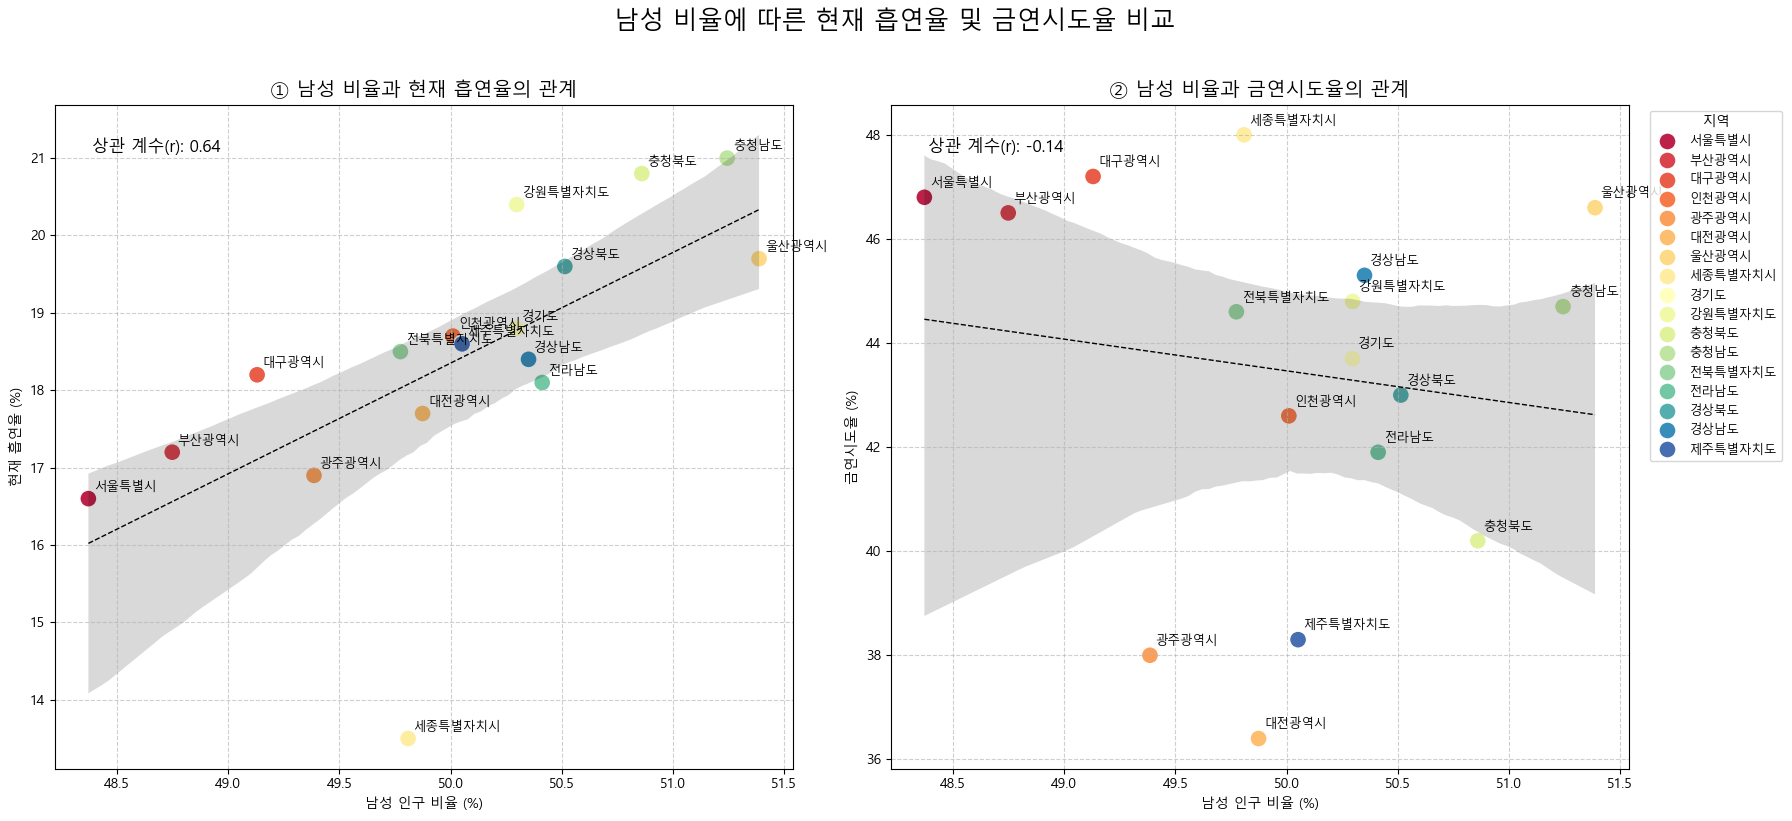

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# final_df는 사용자님의 메모리상에 정의되어 있어야 합니다.

# 1. 상관 계수 계산 (final_df에 남성비율(%), 흡연율(%), 금연시도율(%) 컬럼이 있다고 가정)
corr_smoking = final_df['남성비율(%)'].corr(final_df['흡연율(%)'])
corr_cessation = final_df['남성비율(%)'].corr(final_df['금연시도율(%)'])

# 2. 시각화 설정 (1행 2열 레이아웃)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle(f'남성 비율에 따른 현재 흡연율 및 금연시도율 비교', fontsize=18, y=1.02)


# --- Plot 1: 남성 비율 vs. 흡연율 (회귀선 및 지역별 색상 적용) ---
# 1. 지역별 색상이 적용된 산점도
sns.scatterplot( 
    data=final_df, 
    x='남성비율(%)', 
    y='흡연율(%)', 
    ax=axes[0], 
    s=150, 
    hue='지역',         # 🔥 지역별 색상 적용
    palette='Spectral', 
    legend=False 
)

# 2. 회귀선과 신뢰 구간만 별도로 추가
sns.regplot(
    data=final_df, 
    x='남성비율(%)', 
    y='흡연율(%)', 
    ax=axes[0], 
    scatter=False,      # 점은 그리지 않음
    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, # 전체 추세선
    ci=95
)

axes[0].set_title('① 남성 비율과 현재 흡연율의 관계', fontsize=14)
axes[0].set_xlabel('남성 인구 비율 (%)')
axes[0].set_ylabel('현재 흡연율 (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 텍스트 표시
axes[0].text(0.05, 0.95, f'상관 계수(r): {corr_smoking:.2f}', 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가 (Y_OFFSET 사용)
Y_OFFSET_1 = 0.1 
for i in range(len(final_df)):
    axes[0].text(
        final_df['남성비율(%)'].iloc[i] * 1.0005, 
        final_df['흡연율(%)'].iloc[i] + Y_OFFSET_1, 
        final_df['지역'].iloc[i], 
        fontsize=9,
        color='black'
    )

# --- Plot 2: 남성 비율 vs. 금연시도율 (회귀선 및 지역별 색상 적용) ---
# 1. 지역별 색상이 적용된 산점도
sns.scatterplot( 
    data=final_df, 
    x='남성비율(%)', 
    y='금연시도율(%)', 
    ax=axes[1], 
    s=150, 
    hue='지역',         # 🔥 지역별 색상 적용
    palette='Spectral', 
)

# 2. 회귀선과 신뢰 구간만 별도로 추가
sns.regplot(
    data=final_df, 
    x='남성비율(%)', 
    y='금연시도율(%)', 
    ax=axes[1], 
    scatter=False,      # 점은 그리지 않음
    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
    ci=95
)

axes[1].set_title('② 남성 비율과 금연시도율의 관계', fontsize=14)
axes[1].set_xlabel('남성 인구 비율 (%)')
axes[1].set_ylabel('금연시도율 (%)')
axes[1].grid(True, linestyle='--', alpha=0.6)

# 상관 계수 텍스트 표시
axes[1].text(0.05, 0.95, f'상관 계수(r): {corr_cessation:.2f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
Y_OFFSET_2 = 0.2
for i in range(len(final_df)):
    axes[1].text(
        final_df['남성비율(%)'].iloc[i] * 1.0005, 
        final_df['금연시도율(%)'].iloc[i] + Y_OFFSET_2, 
        final_df['지역'].iloc[i], 
        fontsize=9,
        color='black'
    )
    
# 범례 조정 (Plot 2의 범례를 사용)
axes[1].legend(title='지역', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=9)


plt.tight_layout()
plt.show()

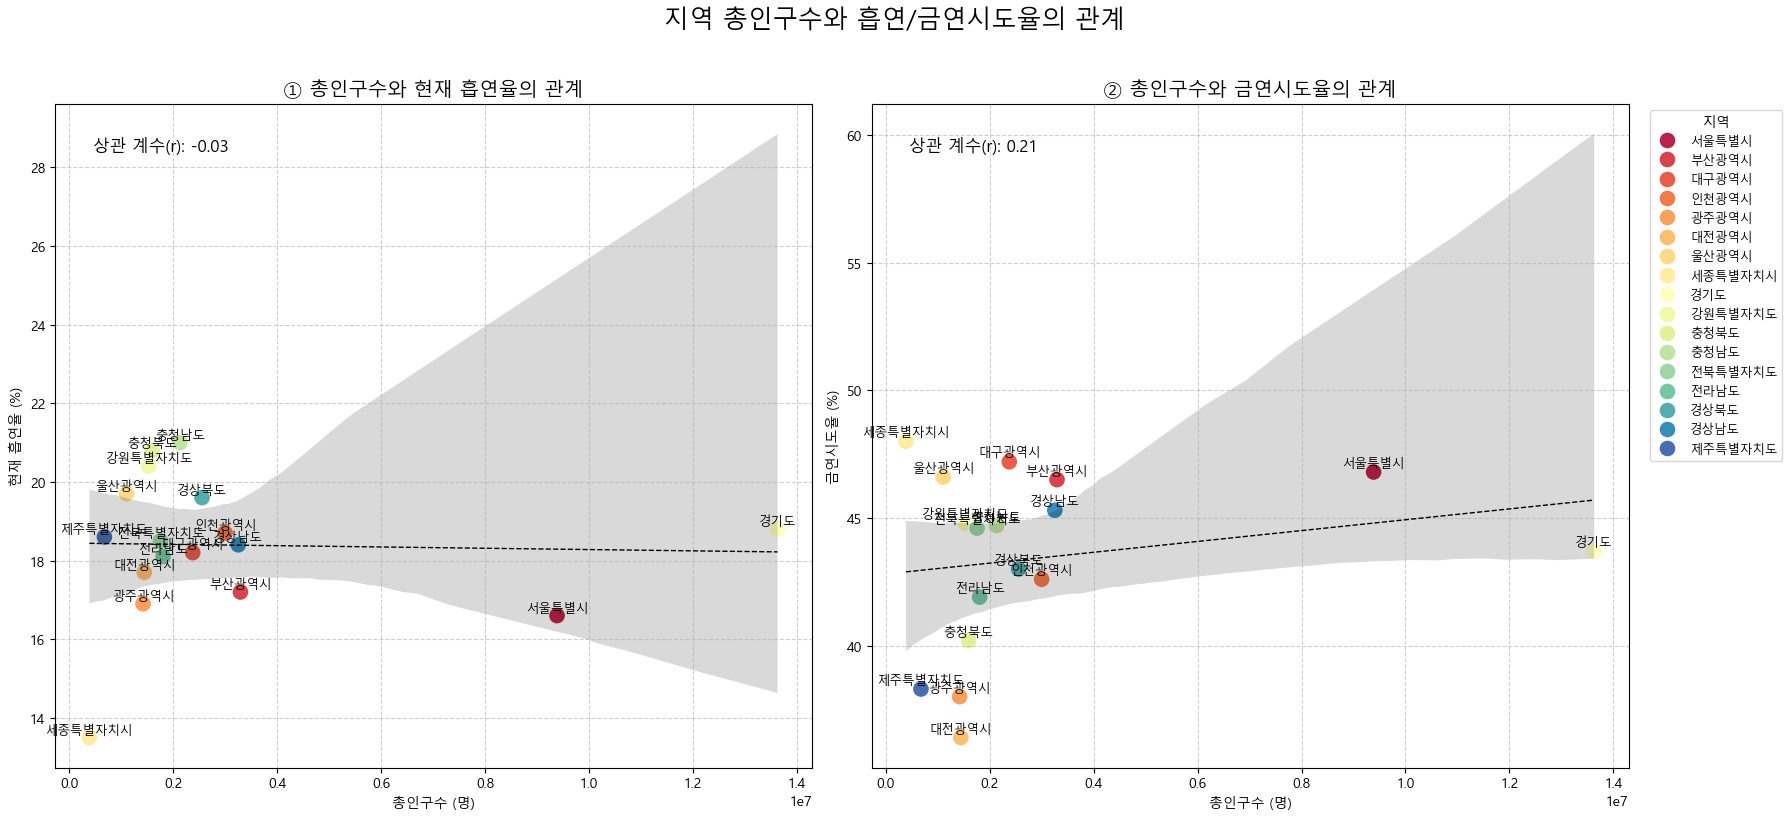

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# 파일 경로 및 연도
SMOKING_RATE_FILE = 'data/현재흡연율.csv'
CESSATION_RATE_FILE = 'data/금연시도율.csv'
GENDER_POPULATION_FILE = 'data/성별_인구수.csv'
YEAR = '2023'
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}

# --- 1. 총인구수 데이터 처리 함수 (인덱스 사용) ---
def load_and_process_gender_pop_by_index(file_path):
    """성별 인구수 데이터를 로드하고 지역별 총인구수를 인덱스로 추출합니다."""
    try:
        # 헤더를 2줄로 읽고 인덱스 기반으로 접근합니다.
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        return pd.DataFrame()
    
    # 0번 인덱스: 지역, 7번 인덱스: 2023년 총인구수
    # .iloc을 사용하여 위치 인덱스로 컬럼을 추출합니다.
    df_pop = df.iloc[:, [0, 7]].copy()
    
    # 컬럼 이름 지정
    df_pop.columns = ['지역', '총인구수 (명)']
    
    # 불필요한 행 제거 및 지역 이름 통일
    df_pop = df_pop[df_pop['지역'] != '전국'].copy()
    df_pop['지역'] = df_pop['지역'].replace(REGION_NAME_MAP)
    
    df_pop['총인구수 (명)'] = pd.to_numeric(df_pop['총인구수 (명)'], errors='coerce')
    
    return df_pop.dropna()

# --- 2. 흡연 지표 데이터 처리 함수 (인덱스 사용) ---
def load_and_process_smoking_data_by_index(file_path, col_name):
    """흡연/금연시도율 데이터를 로드하고 조율을 인덱스로 추출합니다."""
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        return pd.DataFrame()
    
    # 0번 인덱스: 지역, 12번 인덱스: 2023년 조율 (%)
    # .iloc을 사용하여 위치 인덱스로 컬럼을 추출합니다.
    df_rate = df.iloc[:, [0, 12]].copy()
    
    # 컬럼 이름 지정
    df_rate.columns = ['지역', col_name] 

    # 불필요한 행 제거 및 지역 이름 통일
    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)'] 
    
    df_rate[col_name] = pd.to_numeric(df_rate[col_name], errors='coerce')
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# --- 데이터 로드 및 병합 실행 ---
pop_df_total = load_and_process_gender_pop_by_index(GENDER_POPULATION_FILE)
smoking_df = load_and_process_smoking_data_by_index(SMOKING_RATE_FILE, '흡연율(%)')
cessation_df = load_and_process_smoking_data_by_index(CESSATION_RATE_FILE, '금연시도율(%)')

merged_temp = pd.merge(pop_df_total, smoking_df, on='지역', how='inner')
final_df_total = pd.merge(merged_temp, cessation_df, on='지역', how='inner')


# 2. 상관 계수 계산
X_COL = '총인구수 (명)'
corr_smoking = final_df_total[X_COL].corr(final_df_total['흡연율(%)'])
corr_cessation = final_df_total[X_COL].corr(final_df_total['금연시도율(%)'])


# 3. 시각화 코드 (이전과 동일)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle(f'지역 총인구수와 흡연/금연시도율의 관계', fontsize=18, y=1.02)


# --- Plot 1: 총인구수 vs. 흡연율 ---
sns.scatterplot( 
    data=final_df_total, 
    x=X_COL, 
    y='흡연율(%)', 
    ax=axes[0], 
    s=150, 
    hue='지역',         
    palette='Spectral', 
    legend=False 
)
sns.regplot(
    data=final_df_total, 
    x=X_COL, 
    y='흡연율(%)', 
    ax=axes[0], 
    scatter=False,      
    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
    ci=95
)

axes[0].set_title('① 총인구수와 현재 흡연율의 관계', fontsize=14)
axes[0].set_xlabel('총인구수 (명)')
axes[0].set_ylabel('현재 흡연율 (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[0].text(0.05, 0.95, f'상관 계수(r): {corr_smoking:.2f}', 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
Y_OFFSET_1 = 0.1 
for i in range(len(final_df_total)):
    axes[0].text(
        final_df_total[X_COL].iloc[i], 
        final_df_total['흡연율(%)'].iloc[i] + Y_OFFSET_1, 
        final_df_total['지역'].iloc[i], 
        fontsize=9,
        color='black',
        ha='center' 
    )


# --- Plot 2: 총인구수 vs. 금연시도율 ---
sns.scatterplot( 
    data=final_df_total, 
    x=X_COL, 
    y='금연시도율(%)', 
    ax=axes[1], 
    s=150, 
    hue='지역',         
    palette='Spectral', 
)
sns.regplot(
    data=final_df_total, 
    x=X_COL, 
    y='금연시도율(%)', 
    ax=axes[1], 
    scatter=False,      
    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
    ci=95
)

axes[1].set_title('② 총인구수와 금연시도율의 관계', fontsize=14)
axes[1].set_xlabel('총인구수 (명)')
axes[1].set_ylabel('금연시도율 (%)')
axes[1].grid(True, linestyle='--', alpha=0.6)

axes[1].text(0.05, 0.95, f'상관 계수(r): {corr_cessation:.2f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# 지역 이름 레이블 추가
Y_OFFSET_2 = 0.2
for i in range(len(final_df_total)):
    axes[1].text(
        final_df_total[X_COL].iloc[i], 
        final_df_total['금연시도율(%)'].iloc[i] + Y_OFFSET_2, 
        final_df_total['지역'].iloc[i], 
        fontsize=9,
        color='black',
        ha='center'
    )
    
# 범례 조정 
axes[1].legend(title='지역', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=9)


plt.tight_layout()
plt.show()

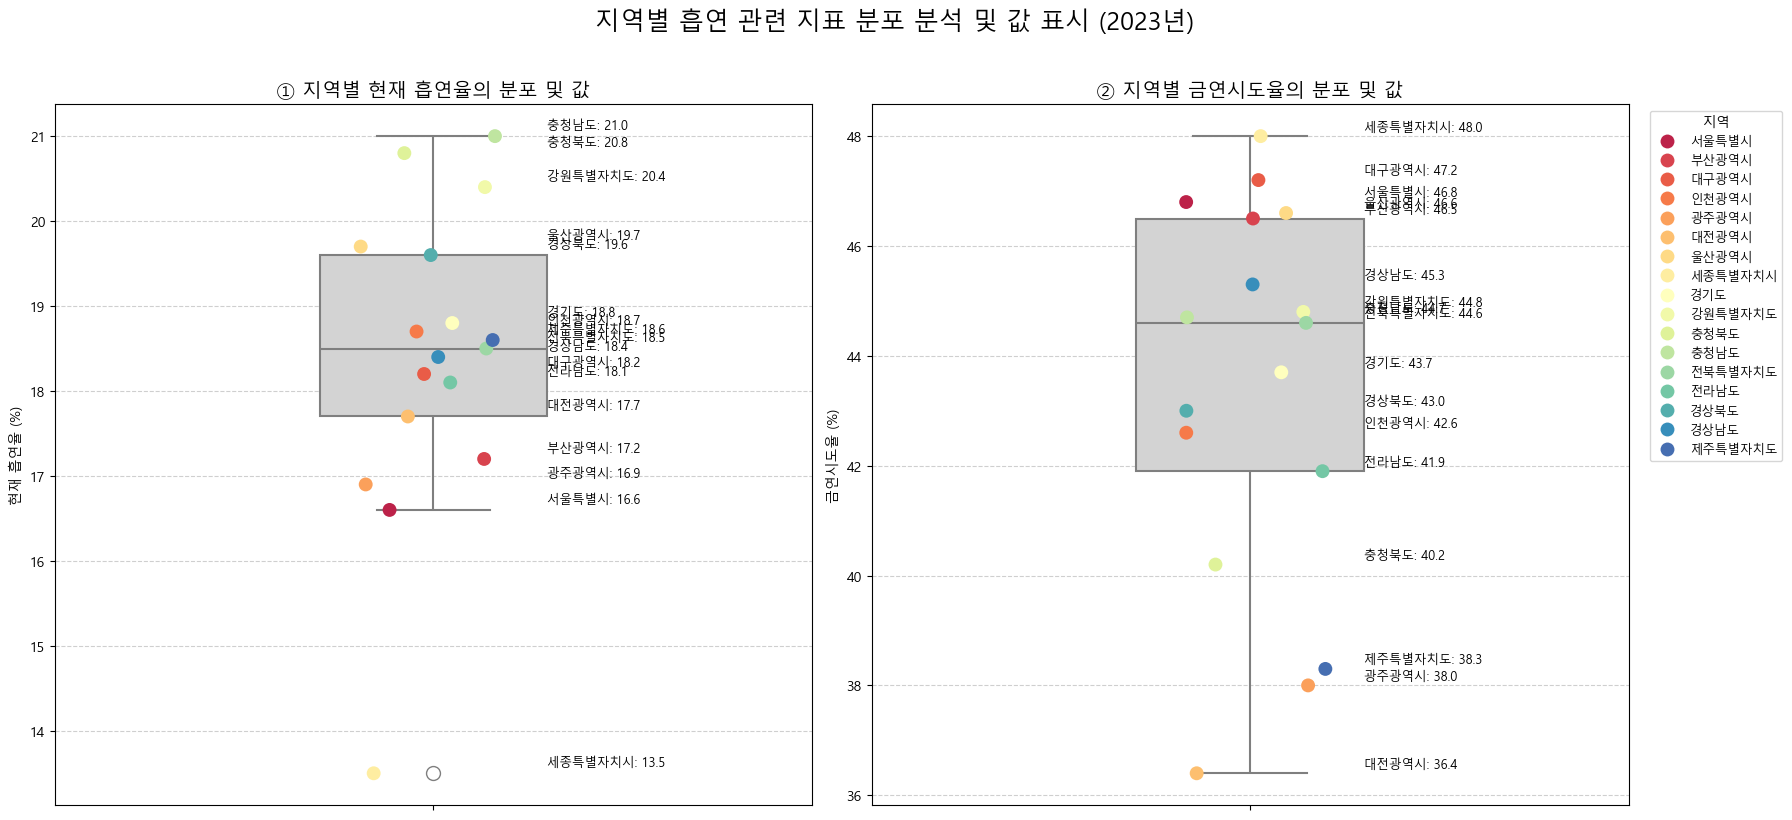

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# final_df_total 데이터프레임이 준비되었다고 가정합니다.
# X_COL은 '총인구수 (명)', Y_COL_1은 '흡연율(%)', Y_COL_2는 '금연시도율(%)'이라고 가정합니다.
X_COL = '총인구수 (명)' 
Y_COL_1 = '흡연율(%)'
Y_COL_2 = '금연시도율(%)'


fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle(f'지역별 흡연 관련 지표 분포 분석 및 값 표시 ({YEAR}년)', fontsize=18, y=1.02)

# --- Plot 1: 현재 흡연율 분포 (Box Plot + Strip Plot + Text Label) ---

# 1. Box Plot: 전체 데이터의 분포
sns.boxplot(
    y=final_df_total[Y_COL_1], 
    ax=axes[0], 
    color='lightgray', 
    width=0.3,
    linewidth=1.5,
    fliersize=10 
)

# 2. Strip Plot: 각 지역의 점을 색상으로 표시
sns.stripplot(
    y=final_df_total[Y_COL_1], 
    x=[''] * len(final_df_total), # X축에 임의의 레이블을 지정하여 Box Plot과 겹치게 만듭니다.
    ax=axes[0], 
    hue=final_df_total['지역'], 
    size=10, 
    jitter=True, 
    palette='Spectral',
    legend=False 
)

# 3. 🔥🔥 지역 이름과 데이터 값 표시 🔥🔥
TEXT_OFFSET_X = 0.15 # X축의 미세한 오프셋 조정 (점이 겹쳐있으므로)
TEXT_OFFSET_Y = 0.05 # Y축의 미세한 오프셋 조정 (점 위에 표시)

for i, row in final_df_total.iterrows():
    # 흡연율 값 포맷팅 (예: 18.2)
    label = f"{row['지역']}: {row[Y_COL_1]:.1f}"
    
    # x 좌표를 Strip Plot의 x 위치 (0)와 오프셋을 조정하여 설정
    axes[0].text(
        0 + TEXT_OFFSET_X, 
        row[Y_COL_1] + TEXT_OFFSET_Y, 
        label, 
        fontsize=9,
        color='black',
        ha='left',  # 텍스트를 오른쪽으로 정렬하여 점 옆에 표시
        va='bottom' # 점 위에 표시
    )

axes[0].set_title('① 지역별 현재 흡연율의 분포 및 값', fontsize=14)
axes[0].set_ylabel('현재 흡연율 (%)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', labelrotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# --- Plot 2: 금연시도율 분포 (Box Plot + Strip Plot + Text Label) ---

# 1. Box Plot: 전체 데이터의 분포
sns.boxplot(
    y=final_df_total[Y_COL_2], 
    ax=axes[1], 
    color='lightgray', 
    width=0.3,
    linewidth=1.5,
    fliersize=10
)

# 2. Strip Plot: 각 지역의 점을 색상으로 표시
sns.stripplot(
    y=final_df_total[Y_COL_2], 
    x=[''] * len(final_df_total),
    ax=axes[1], 
    hue=final_df_total['지역'], 
    size=10, 
    jitter=True, 
    palette='Spectral',
)

# 3. 🔥🔥 지역 이름과 데이터 값 표시 🔥🔥
for i, row in final_df_total.iterrows():
    # 금연시도율 값 포맷팅 (예: 42.6)
    label = f"{row['지역']}: {row[Y_COL_2]:.1f}"
    
    axes[1].text(
        0 + TEXT_OFFSET_X, 
        row[Y_COL_2] + TEXT_OFFSET_Y, 
        label, 
        fontsize=9,
        color='black',
        ha='left',
        va='bottom'
    )

axes[1].set_title('② 지역별 금연시도율의 분포 및 값', fontsize=14)
axes[1].set_ylabel('금연시도율 (%)')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', labelrotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# 범례 조정 (Plot 2의 범례를 사용)
axes[1].legend(title='지역', loc='upper left', bbox_to_anchor=(1.02, 1), ncol=1, fontsize=9)


plt.tight_layout()
plt.show()

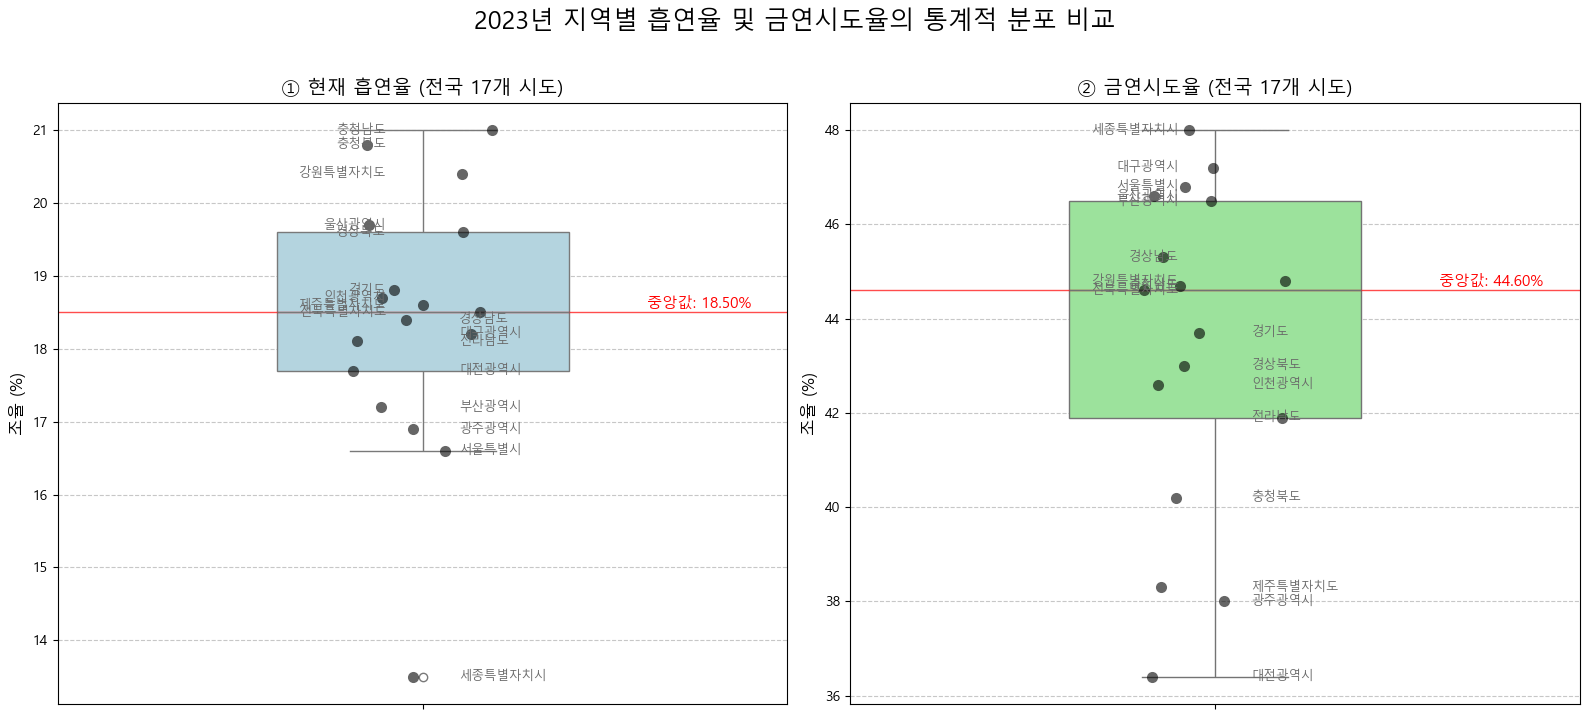

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 파일 경로 및 연도 정의 (기존 코드와 동일)
SMOKING_RATE_FILE = 'data/현재흡연율.csv'
CESSATION_RATE_FILE = 'data/금연시도율.csv'
YEAR = '2023'
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 파일 경로 및 연도 정의 (기존 코드와 동일)
# SMOKING_RATE_FILE = '현재흡연율.csv'
# CESSATION_RATE_FILE = '금연시도율.csv'
# YEAR = '2023'
# REGION_NAME_MAP = {
#     '강원도': '강원특별자치도', 
#     '전라북도': '전북특별자치도', 
#     '제주도': '제주특별자치도'
# }


# --- 1. 데이터 로드 및 전처리 함수 정의 (재사용) ---

def load_and_process_smoking_data_by_index(file_path, col_name):
    """흡연/금연시도율 데이터를 로드하고 조율을 인덱스로 추출합니다."""
    # 파일 로드 및 전처리 로직은 기존과 동일하다고 가정합니다.
    # 안전을 위해 실제 코드 실행 시에는 위에 정의된 함수를 사용합니다.
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        print(f"오류: 파일 경로를 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()
    
    # 0번 인덱스: 지역, 12번 인덱스: 2023년 조율 (%)
    df_rate = df.iloc[:, [0, 12]].copy()
    
    df_rate.columns = ['지역', col_name] 

    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)'] 
    
    df_rate[col_name] = pd.to_numeric(df_rate[col_name], errors='coerce')
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# --- 2. 데이터 로드 및 병합 실행 ---
smoking_df_2023 = load_and_process_smoking_data_by_index('data/현재흡연율.csv', '흡연율(%)')
cessation_df_2023 = load_and_process_smoking_data_by_index('data/금연시도율.csv', '금연시도율(%)')

# --------------------------------------------------------------------------------
# 3. 서브플롯 박스 플롯 시각화 (Subplots Box Plot Visualization)
# --------------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
plt.suptitle('2023년 지역별 흡연율 및 금연시도율의 통계적 분포 비교', fontsize=18, y=1.02)


# --- Plot 1: 현재 흡연율 분포 ---
sns.boxplot(
    data=smoking_df_2023,
    y='흡연율(%)',
    ax=axes[0],
    color='#ADD8E6', # 연한 파란색
    width=0.4
)
# 스트립 플롯 (지역별 데이터 포인트) 오버레이
sns.stripplot(
    data=smoking_df_2023,
    y='흡연율(%)',
    ax=axes[0],
    color='black',
    size=8,
    alpha=0.6,
    jitter=0.1 # 지점 분산 정도
)

axes[0].set_title('① 현재 흡연율 (전국 17개 시도)', fontsize=14)
axes[0].set_xlabel('') # X축 레이블 제거
axes[0].set_ylabel('조율 (%)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Plot 2: 금연시도율 분포 ---
sns.boxplot(
    data=cessation_df_2023,
    y='금연시도율(%)',
    ax=axes[1],
    color='#90EE90', # 연한 녹색
    width=0.4
)
# 스트립 플롯 (지역별 데이터 포인트) 오버레이
sns.stripplot(
    data=cessation_df_2023,
    y='금연시도율(%)',
    ax=axes[1],
    color='black',
    size=8,
    alpha=0.6,
    jitter=0.1
)

axes[1].set_title('② 금연시도율 (전국 17개 시도)', fontsize=14)
axes[1].set_xlabel('') # X축 레이블 제거
axes[1].set_ylabel('조율 (%)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)


# --- 텍스트 레이블 추가 (중앙값 표시) ---
for ax, df, title in zip(axes, [smoking_df_2023, cessation_df_2023], ['흡연율(%)', '금연시도율(%)']):
    median_val = df[title].median()
    
    # 중앙값 라인 (박스 중앙값)
    ax.axhline(median_val, color='red', linestyle='-', linewidth=1, alpha=0.7)
    
    # 중앙값 텍스트
    ax.text(ax.get_xlim()[1] * 0.9, median_val, 
            f'중앙값: {median_val:.2f}%', 
            color='red', fontsize=11, ha='right', va='bottom')
    
    # 지역 이름 레이블 추가
    for i in range(len(df)):
        x_text_pos = 0.05 if df[title].iloc[i] < median_val else -0.05 # 중앙값 기준으로 왼쪽/오른쪽으로 분산
        ha_align = 'left' if df[title].iloc[i] < median_val else 'right'
        
        ax.text(x_text_pos, df[title].iloc[i],
                df['지역'].iloc[i],
                fontsize=9,
                color='dimgray',
                ha=ha_align,
                va='center')


plt.tight_layout()
plt.show()

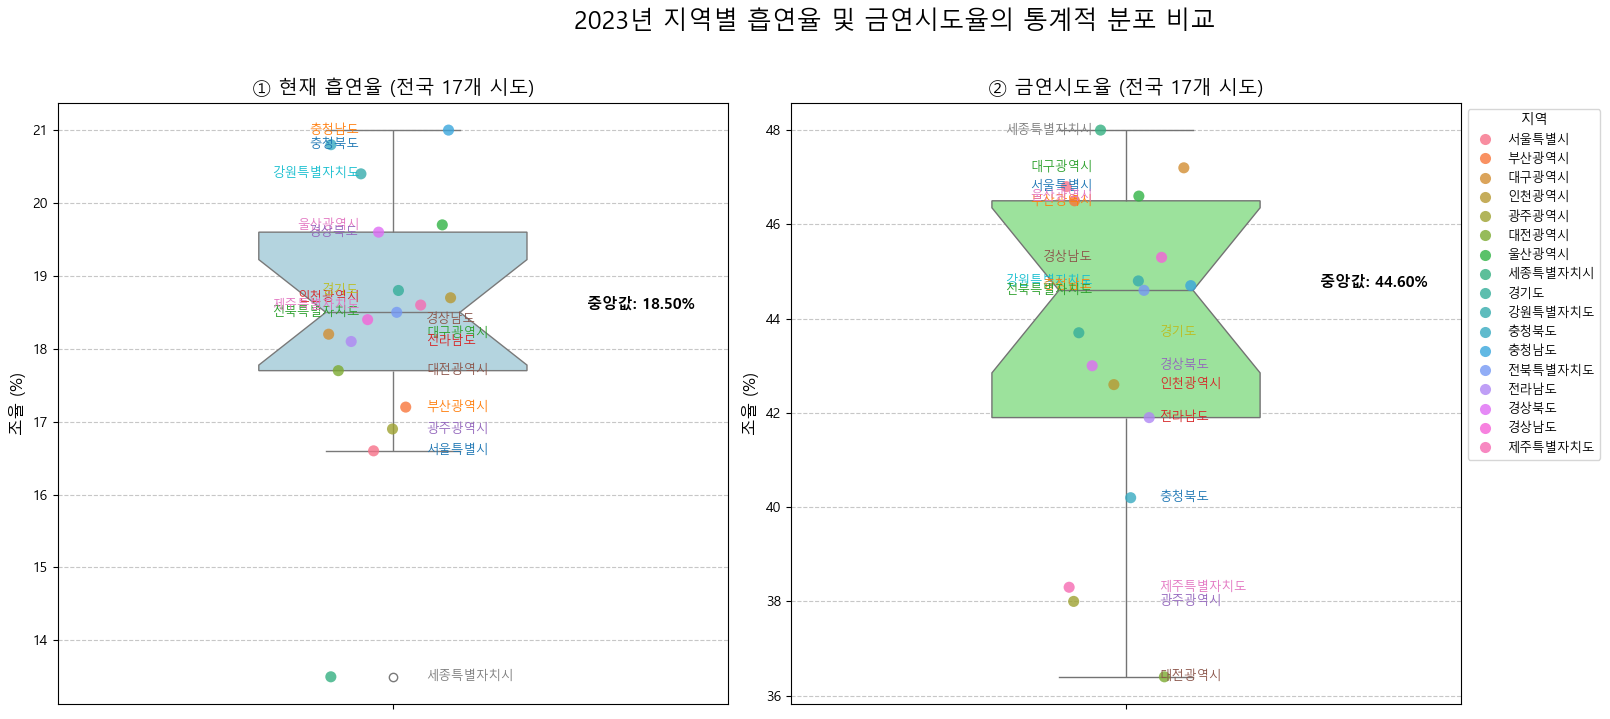

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 파일 경로 및 연도 정의 (기존 코드와 동일)
SMOKING_RATE_FILE = 'data/현재흡연율.csv'
CESSATION_RATE_FILE = 'data/금연시도율.csv'
YEAR = '2023'
REGION_NAME_MAP = {
    '강원도': '강원특별자치도', 
    '전라북도': '전북특별자치도', 
    '제주도': '제주특별자치도'
}


# --- 1. 데이터 로드 및 전처리 함수 정의 (재사용) ---

def load_and_process_smoking_data_by_index(file_path, col_name):
    """흡연/금연시도율 데이터를 로드하고 조율을 인덱스로 추출합니다."""
    # 파일 로드 및 전처리 로직은 동일하다고 가정
    try:
        df = pd.read_csv(file_path, header=[0, 1])
    except FileNotFoundError:
        return pd.DataFrame()
    
    # 0번 인덱스: 지역, 12번 인덱스: 2023년 조율 (%)
    df_rate = df.iloc[:, [0, 12]].copy()
    
    df_rate.columns = ['지역', col_name] 

    df_rate = df_rate[df_rate['지역'] != '전국']
    df_rate = df_rate[df_rate['지역'] != '시군구별(1)'] 
    
    df_rate[col_name] = pd.to_numeric(df_rate[col_name], errors='coerce')
    df_rate['지역'] = df_rate['지역'].replace(REGION_NAME_MAP)
    
    return df_rate.dropna()


# --- 2. 데이터 로드 및 병합 실행 ---
smoking_df_2023 = load_and_process_smoking_data_by_index(SMOKING_RATE_FILE, '흡연율(%)')
cessation_df_2023 = load_and_process_smoking_data_by_index(CESSATION_RATE_FILE, '금연시도율(%)')

# --------------------------------------------------------------------------------
# 3. 서브플롯 박스 플롯 시각화 (Subplots Box Plot Visualization)
# --------------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
plt.suptitle('2023년 지역별 흡연율 및 금연시도율의 통계적 분포 비교', fontsize=18, y=1.02)


# 박스 플롯 배경색 설정
box_colors = ['#ADD8E6', '#90EE90'] 


# --- Plot 1: 현재 흡연율 분포 ---
sns.boxplot(
    data=smoking_df_2023,
    y='흡연율(%)',
    ax=axes[0],
    color=box_colors[0], 
    width=0.4,
    notch=True # 중앙값 스타일 적용
)
# 스트립 플롯 (지역별 데이터 포인트) 오버레이 및 색상 적용
sns.stripplot(
    data=smoking_df_2023,
    y='흡연율(%)',
    hue='지역', # 지역별로 색상 구분
    ax=axes[0],
    size=8,
    alpha=0.8,
    jitter=0.1,
    legend=False # 범례는 Plot 2에서 통합 표시
)

axes[0].set_title('① 현재 흡연율 (전국 17개 시도)', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('조율 (%)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)


# --- Plot 2: 금연시도율 분포 ---
sns.boxplot(
    data=cessation_df_2023,
    y='금연시도율(%)',
    ax=axes[1],
    color=box_colors[1], 
    width=0.4,
    notch=True
)
# 스트립 플롯 (지역별 데이터 포인트) 오버레이 및 색상 적용
sns.stripplot(
    data=cessation_df_2023,
    y='금연시도율(%)',
    hue='지역', # 지역별로 색상 구분
    ax=axes[1],
    size=8,
    alpha=0.8,
    jitter=0.1
)

axes[1].set_title('② 금연시도율 (전국 17개 시도)', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('조율 (%)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# --- 텍스트 레이블 추가 ---
for ax, df, title in zip(axes, [smoking_df_2023, cessation_df_2023], ['흡연율(%)', '금연시도율(%)']):
    # 중앙값 텍스트 추가
    median_val = df[title].median()
    
    ax.text(ax.get_xlim()[1] * 0.9, median_val, 
            f'중앙값: {median_val:.2f}%', 
            color='black', fontsize=11, ha='right', va='bottom', fontweight='bold')
    
    # 지역 이름 레이블 추가 (중앙값 기준 분산)
    for i in range(len(df)):
        x_text_pos = 0.05 if df[title].iloc[i] < median_val else -0.05 
        ha_align = 'left' if df[title].iloc[i] < median_val else 'right'
        
        # stripplot이 사용하는 동일한 색상 팔레트에서 지역의 색상을 가져옴
        region_color = sns.color_palette('tab10', n_colors=len(df['지역'].unique()))[i % len(df['지역'].unique())]
        
        ax.text(x_text_pos, df[title].iloc[i],
                df['지역'].iloc[i],
                fontsize=9,
                color=region_color, # 지역별 색상 적용
                ha=ha_align,
                va='center')


# 범례를 Plot 2 바깥에 통합하여 표시
h, l = axes[1].get_legend_handles_labels()
axes[1].legend(h, l, title='지역', loc='upper left', bbox_to_anchor=(1.0, 1), ncol=1, fontsize=9)


plt.tight_layout(rect=[0, 0, 0.9, 1]) # 범례 공간 확보
plt.show()